# Modeling of Salary by role features

## Excercise for Indeed.com 

- Run these cells in order to obtain results.
- Use the notebook SplitTrainCSV.ipynb to create separate Train, Validation and Test data used in this notebook.
- Approaches used include Bayesian MAP, K Nearest Neighbors Regression, Decision Tree Regression, Random Forest Regression, Simple Averaging by Feature, Neural Network, and Ensemble Averaging of all features.

## Requires Keras, Tensorflow, Python 3.x and Pandas to run

# Required imports

In [76]:
import keras

import pystan

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from keras.models import model_from_json

import pandas as pd
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.utils import shuffle


from numpy import random
from sklearn.metrics import r2_score


from timeit import default_timer as timer
import pickle
plt.rc('axes', linewidth=2)

%matplotlib inline

##list methods to be compared
methods = ['bayes', 'knn', 'tree', 'forest','nn', 'ave']

In [77]:
def improve_plot(ax, xlabel, ylabel, nxticks=4, nyticks=2):
    '''
    Function to improve plots with bold labels and tickmarks
    
    Inputs: 
         ax: matplotlib axis object
         xlabel, ylabel: label names for x and y
         nxticks, nyticks: number of tick marks to include for x and y axis
         despine: provide a bit of space 
    '''
    plt.locator_params(axis='y', nbins=nyticks)
    plt.locator_params(axis='x', nbins=nxticks)
    ax.set_xlabel(xlabel, fontsize=34, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=34, fontweight='bold')
    ylabels = ax.get_yticks()
    ylabels = [str(np.round(float(label),3)) for label in ylabels]
    ax.set_xticklabels(ax.get_xticks(),fontsize=16, fontweight='bold')
    ax.set_yticklabels(ylabels,fontsize=16, fontweight='bold')

    

# Read data  
- Data were previously split into Train-Validation-Test datasets using SplitTrainCSV.ipynb
- See Jupter Notebook EDA.ipynb to see some basic exploratory data analysis

In [78]:
data_dir = './'

##read data from TRAIN, VALIDATION, and TEST datasets (previously split used SplitTrainCSV.ipynb)
##note: TEST dataset is only used for final output.  Do not use to for adjusting hyperparameters
df_train = pd.read_csv(data_dir + 'TRAIN.csv')
df_validation = pd.read_csv(data_dir + 'VALID.csv')
df_test = pd.read_csv(data_dir + 'TEST.csv')

##shuffle the TRAIN and VALIDATION datasets data to prevent overtraining on order
##not necessary to shuffle TEST datasets but, doesn't hurt
df_train = shuffle(df_train, random_state=32)
df_validation = shuffle(df_validation, random_state=32)
df_test = shuffle(df_test, random_state=32)

print(len(df_train), len(df_validation), len(df_test))
##as noted, the target data are positively skewed.  Transformation made little difference
##on the prediction accuracy of the model but is included here

200000 100000 199999


In [79]:
df_test.head()

jobId companyId         jobType       degree        major  \
13284   JOB1362684887204    COMP26             CEO         NONE         NONE   
111718  JOB1362685228559    COMP46         JANITOR  HIGH_SCHOOL         NONE   
151584  JOB1362685061728     COMP8             CTO     DOCTORAL  ENGINEERING   
69997   JOB1362684567360     COMP0         MANAGER    BACHELORS         NONE   
101185  JOB1362685061079    COMP45  VICE_PRESIDENT  HIGH_SCHOOL         NONE   

       industry  yearsExperience  milesFromMetropolis  salary  
13284       OIL               24                   47     129  
111718      OIL                7                   58      86  
151584     AUTO               12                   33     126  
69997    HEALTH                5                   61     109  
101185      WEB               13                   57     144

# The following are 'hard coded' ordinal values for the data.  
- The values are in a natural order, e.g., NONE and HIGH_SCHOOL have lower values than DOCTORAL
- Labels for degree, jobType, industry and major are coded into integer values.  Confirmed by inspecting means at each level.
- Continuous variables (yearsExperience, milesFromMetropolis) were discretized into 10 bins each.
- mileFromMetropolis reversed to be 'nearness to metropolis' 


In [80]:
ordinal_values = {"degree": {"NONE": 1, "HIGH_SCHOOL": 2,
                              "BACHELORS": 3, "MASTERS": 4,
                              "DOCTORAL": 4},                     
                  "jobType": {"JANITOR": 1, "JUNIOR": 2,
                              "SENIOR": 3, "MANAGER": 4,
                              "VICE_PRESIDENT": 5, 
                              "CTO": 6, "CFO": 7, 
                              "CEO": 8},                 
                  "industry": {"EDUCATION": 1, "AUTO": 1,
                               "SERVICE": 2, "HEALTH": 2, "WEB": 2,
                               "OIL": 3, "FINANCE": 3},
                  "major":  {"NONE": 1, "LITERATURE": 2, 
                             "BIOLOGY": 3, "CHEMISTRY": 3,
                             "PHYSICS": 4, "MATH": 4,
                             "COMPSCI": 5, "ENGINEERING": 5, "BUSINESS": 5}}



def ordinalize_data(df):
    '''
    Function to replace categorical values with ordinal values.
    Input: Pandas DataFrame containing categorical labels to be ordinalized.
    Output: Pandas DataFrame with categorical labels replaced with ordinal values
    '''
    
    df.replace(ordinal_values, inplace=True)

    ##note the following may produce slightly different cuts --if importand ad in the data prep
    df['distance'] = pd.cut(df.milesFromMetropolis, 
                              10, labels=list(range(10,0,-1)))

    df['years'] = pd.cut(df.yearsExperience, 10, labels=list(range(1,11)))
    df = df.astype({'years': 'int32', 'distance': 'int32'})
    return df

##run the ordinalize function on all DataFrames to be used in the training and testing
##N.B. would be slightly better if this were done in SplitTrainCSV.ipynb

df_train = ordinalize_data(df_train)
df_validation = ordinalize_data(df_validation)
df_test = ordinalize_data(df_test)

In [81]:
df_train.head()

##examine correlationship between columns

#df_test.corr()

jobId companyId  jobType  degree  major  industry  \
13284   JOB1362684481526    COMP19        6       3      2         3   
111718  JOB1362685133390    COMP41        8       1      1         1   
151584  JOB1362684850934    COMP10        5       1      1         2   
69997   JOB1362685030888    COMP61        2       2      1         1   
101185  JOB1362685338688    COMP29        7       2      1         1   

        yearsExperience  milesFromMetropolis  salary  distance  years  
13284                21                    9     177        10      9  
111718               16                   74     121         3      7  
151584               11                   12     123         9      5  
69997                13                    3      81        10      6  
101185               24                   70     103         3     10

In [82]:
##create an empty Pandas DataFrame to hold results

df_results = pd.DataFrame()

# Make training data set for sklearn and neural net models
- Training data are used for several models (neural net, decision tree, random forest, and k nearest neighbors


In [83]:
# split into input (X) and output (Y) variables

X = np.hstack([df_train.jobType.values.reshape(-1,1), 
               df_train.years.values.reshape(-1,1),
               df_train.degree.values.reshape(-1,1),
               df_train.distance.values.reshape(-1,1),
               df_train.industry.values.reshape(-1,1),
               df_train.major.values.reshape(-1,1)])

Y = df_train.salary.values


# Build Keras Neural Network Model
- One input layer, three hidden layers (120, 80,20 neurons) and one output layer.
- Dropout regularization
- Batch Normalization at each layer
- Use linear activation functions near output layers
- Use scaling of the feature and target data for training the network
- Hyperparameters are network size, initializers, activation layer (e.g., relu, linear) and # of layers

In [84]:
# define base model
    # create model
model = Sequential()
model.add(Dense(120, input_dim=6, kernel_initializer='normal', activation='relu', use_bias=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(80, kernel_initializer='normal', activation='linear', use_bias=True))  
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(20, kernel_initializer='normal', activation='linear', use_bias=True))  
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='linear',use_bias=True))
# Compile model
model.compile(loss='mse', optimizer='adam')


scalarX, scalarY = RobustScaler(), RobustScaler()
scalarX.fit(X)
scalarY.fit(Y.reshape(-1,1))

tX = scalarX.transform(X)
ty = scalarY.transform(Y.reshape(-1,1))

# Fit the model using six training epochs and a batch size of 128. 
- N.B. These are hyperparameters than can be tuned; however, little difference is seen over a range of values
- Training performance saturates quickly.  Six-10 epochs work well.

In [85]:
model.fit(tX, ty, epochs=6, batch_size=128, verbose=True)
#print(tX[:10])

Epoch 1/6
200000/200000 [==============================] - 10s 51us/step - loss: 0.1693
Epoch 2/6
200000/200000 [==============================] - 10s 49us/step - loss: 0.1658
Epoch 3/6
200000/200000 [==============================] - 9s 47us/step - loss: 0.1651
Epoch 4/6
200000/200000 [==============================] - 11s 53us/step - loss: 0.1651
Epoch 5/6
200000/200000 [==============================] - 9s 47us/step - loss: 0.1646
Epoch 6/6
200000/200000 [==============================] - 8s 42us/step - loss: 0.1646


In [86]:
model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model.h5")

with open('./xtransform.pkl', "wb") as f:
    pickle.dump(scalarX, f)
    

In [87]:
with open('./ytransform.pkl', "wb") as f:
    pickle.dump(scalarY, f)

# function for 'forward pass' through neural net

In [88]:
def run_nn(df, npredictions=5000):
    
    '''Function for running forward pass through neural net.
    Input: 
        df: Pandas DataFrame with training, validation or test data
        npredictions: integer value (default 5000) representing number of predictions to run
    Output:
        y_hat_nn: a vector of predictions
        salary: the ground truth value for each predicted salary
    '''
    
    X = np.hstack([df.jobType.values.reshape(-1,1), 
                   df.years.values.reshape(-1,1),
                   df.degree.values.reshape(-1,1),
                   df.distance.values.reshape(-1,1),
                   df.industry.values.reshape(-1,1),
                   df.major.values.reshape(-1,1)])

    salary = df.salary.values.reshape(-1,1)[:npredictions]
    
    ##transform the feature data 
    X = scalarX.transform(X[:npredictions,:])
    
    # make a prediction
    y_hat_nn = model.predict(X)
    
    #invert the transform to make prediction at original scale
    y_hat_nn = scalarY.inverse_transform(y_hat_nn)[:,0]
  
    return y_hat_nn, salary

In [90]:
##make the forward pass and store the returned results in df_results
start=timer()

y_hat_nn, y_truth = run_nn(df_validation, npredictions=20000)
print('NN time: ', timer()-start)

df_results['y_hat_nn'] = y_hat_nn
df_results['y_truth'] = y_truth
##jobId needed for output dataset
df_results['jobId'] = df_validation.jobId.values[:20000]

NN time:  0.6727195430003121


# Train standard scikit-learn regression models
## Models chosen are:
- K Nearest Neighbors Regresson
- Decision Tree Regressor
- Random Forest Regressor 
- Decision Tree and Random Forest return feature importance

In [91]:
def train_sklearn_regressors(df, ntrain):
    '''
    Function to train nearest neighbors regression.
    
    Input:
         df: Pandas DataFrame with salary data.
         ntrain: number of samples to use for training
    Output:
         neighbors, tree, forest models
    '''

    
    
    X = np.hstack([df.jobType.values.reshape(-1,1), 
                   df.years.values.reshape(-1,1),
                   df.degree.values.reshape(-1,1),
                   df.distance.values.reshape(-1,1),
                   df.industry.values.reshape(-1,1),
                   df.major.values.reshape(-1,1)])
   
    X = X[:ntrain]
    
 
    y = df.salary.values[:ntrain] 

    neighbors = KNeighborsRegressor()
    neighbors.fit(X, y)
    
    #tree = DecisionTreeRegressor(criterion='mae', max_depth=3)  
    tree = DecisionTreeRegressor()  
    # fit the regressor with X and Y data 
    tree.fit(X, y) 
    features = ['Job', 'Years', 'Degree', 'Industry', 'Major']
    for importance, feature in zip(tree.feature_importances_, features):
       print("Tree Feature Importance for: ", feature, " : ", importance)
    
    forest = RandomForestRegressor()
    forest.fit(X,y)
    
    for importance, feature in zip(forest.feature_importances_, features):
       print("Forest Feature Importance for: ", feature, " : ", importance)
    
    return neighbors, tree, forest

neigh, tree, forest = train_sklearn_regressors(df_train, 80000)
    

Tree Feature Importance for:  Job  :  0.40470595688183353
Tree Feature Importance for:  Years  :  0.1915010239861878
Tree Feature Importance for:  Degree  :  0.13489809423334834
Tree Feature Importance for:  Industry  :  0.1484371203464749
Tree Feature Importance for:  Major  :  0.08514117375409283


/opt/anaconda3/envs/stan/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Forest Feature Importance for:  Job  :  0.39141460718984245
Forest Feature Importance for:  Years  :  0.19373175600989445
Forest Feature Importance for:  Degree  :  0.13359584930837815
Forest Feature Importance for:  Industry  :  0.15524998198725629
Forest Feature Importance for:  Major  :  0.08372576333844275


In [92]:
def run_sklearn(df, npredictions = 10000):
    
    '''
    Function for making a forward pass of trained scikit-learn models.
    Input: 
        df: Pandas DataFrame contain data to predict.
        npredictions: the number of predictiont to make (usually the same number for all methods)
    Output:
        y_hat_knn, y_hat_forest, y_hat_tree:  predictions for each type of model
    '''
    
    X = np.hstack([df.jobType.values.reshape(-1,1), 
                   df.years.values.reshape(-1,1),
                   df.degree.values.reshape(-1,1),
                   df.distance.values.reshape(-1,1),
                   df.industry.values.reshape(-1,1),
                   df.major.values.reshape(-1,1)])

    X = X[:npredictions,:]
    y_hat_knn = neigh.predict(X)
    y_hat_forest = forest.predict(X)
    y_hat_tree = tree.predict(X)

    return y_hat_knn, y_hat_forest, y_hat_tree

In [93]:
# Run forward pass of data (test) and store results in df_results
start = timer()
y_hat_knn, y_hat_forest, y_hat_tree = run_sklearn(df_validation, npredictions=20000)
print("scikit-learn models, combined time:", timer()-start)


df_results['y_hat_knn'] = y_hat_knn
df_results['y_hat_tree'] = y_hat_tree
df_results['y_hat_forest'] = y_hat_forest

scikit-learn models, combined time: 1.2747684860005393


# Stan Model--a Baysian regression model specified in PyStan
- Pystan documentation can be found here: https://pystan.readthedocs.io/en/latest/

## Sections are:
- data:  where the data to be passed to the model are definded
- parameters: where the model parameters are define
- transformed parameters: where transformations of the model parameters are defined--in this case, a regression model
- model:  where the priors and model are defined

- Model is specified inline but can be external

In [94]:
model = """


data {
  int<lower=0> N; 
  int<lower=0> J;  //number of job levels
  int<lower=0> K;
  int<lower=1,upper=8> job[N];
  int<lower=1,upper=5> degree[N];
  vector[N] years;
  vector[N] dist;
  vector[N] industry;
  vector[N] major;
  vector[N] y;
} 


parameters {
  vector[J] a;
  vector[K] b;
  real beta[4];
  real sigma;
}


transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <-  beta[1] * years[i] + beta[2] * dist[i] +
                 beta[3] * industry[i] + beta[4] * major[i] + 
                 + a[job[i]] + b[degree[i]];

}

model {
  //model priors
  a ~ normal(0, 50);
  b ~ normal(0, 50);
  beta ~ cauchy(0, 60);
  sigma ~ normal(0, 100);

  y ~ normal(y_hat, sigma);

}
"""


# Compile the Stan model
- Models can take approximately 5 minutes to compile so avoid compiling unnecessarily.  No need to compile here unless changes are made to the model.
- Use Pickle to save the model when you are done adjusting the parameters.

In [95]:
sm = pystan.StanModel(model_code=model)

with open('./bayes_model.pkl', "wb") as f:
    pickle.dump(sm, f)
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd7476ee20084025f6b3e0fc8705f73c NOW.


# Run the following cell to load the compiled stan model

In [96]:
sm = pickle.load(open('bayes_model.pkl', 'rb'))

# Define a function for running the model.  
- N.B. This can be scripted instead of in a function but works well when testing a variety of models.

In [97]:
def fit_bayes(model, df, N):
    '''
    Function to fit a bayes stan model for the salary data.  
    Inputs: 
           model=compiled stan model.
           df=training dataset including job, years, degree, dist, industry and major.
           N=number of training samples to use.
           
    Output:
           df_out=a pandas dataframe with model output.
    '''
    
    df_sample = df.sample(N, random_state=11)
    job = df_sample.jobType.values
    degree = df_sample.degree.values
    years = df_sample.years.values
    distance = df_sample.distance.values
    industry = df_sample.industry.values
    major = df_sample.major.values
    salary = df_sample.salary.values
        
    data = {'N': N, 
            'J': len(np.unique(job)),
            'K': len(np.unique(degree)),
            'job': job,
            'degree': degree,
            'years': years,
            'dist': distance,
            'industry': industry,
            'major': major,
            'y': salary}

    fit = sm.sampling(data=data,iter=8000, chains=4, verbose=True)
    
    df_out  =  fit.to_dataframe()  #convert to pandas frame
    print("bayes model is trained.")
    
    return df_out, fit

# Fit the bayes model  
- N is the number of training samples to use.
- N.B. Running this cell is time consuming.  Check the terminial output to ensure the model is running correctly.  Generally, times over 10 minutes indicate the model is not converging.
  

In [98]:
N = 900
df_model, fit = fit_bayes(sm, df_train, N)

bayes model is trained.



# Sample the posterior and create predictions from the Bayes model
-returns a distribution of salary parameters based on sampling all parameters included in the model.

In [99]:
#years,degree,dist,industry
def sample_posterior(features, nsamples=100):
    '''
    Function to sample the posterior and make predictions.
    
    Input:
        df=Pandas DataFrame with the output of the stan model
        features=the features required to make the prediction
        nsample=the number of posterior samples to take.
    Output:
        prediction: the bayes prediction adding intercept and slopes
    ''' 
    a = random.choice(df_model.loc[:,features[0]].values,nsamples)
    b = random.choice(df_model.loc[:,features[1]].values,nsamples)
    slopes = []
    for i in range(1,5):
        slopes.append(random.choice(df_model.loc[:,'beta['+str(i)+']'].values,nsamples))
   
    
    prediction = a + b + (slopes[0]*features[2]) + (slopes[1]*features[3]) + \
                (slopes[2]*features[4]) + (slopes[3]*features[5])
    
    return prediction

# Make predictions using the Bayesian model
- npredictions is the number of samples to use for making estimates.
- nsamples is the number of samples to use for each posterior. 
- substitute the larger test set for the final run.
- Maximum a posteriori is the modal value of the posterior distribution.
- This method could be made faster by eiminating the loop over predictions. 

In [100]:
def bayes_prediction(df, npredictions = 5000, n_bayes_samples=4000):
   
    '''
    Function to predict salary from features using Bayesian Maximum A Posteriori method.
    
    Inputs: 
        df_in, a Pandas DataFrame with feature data.
        npredictions: number of predictions to make.  Default at 5000
        n_bayes_samples: number of posterior samples
            
    Outputs: 
        y-hat_bayes, posterior distribution
    '''
    
  
    df = df.iloc[:npredictions]

    ##extract features for use in predictions
    job = df.jobType.values
    years = df.years.values

    distance = df.distance.values
    degree = df.degree.values
    industry = df.industry.values
    major = df.major.values

    y_hat_bayes = []
    posteriors = []
    
    ##extract salary for computing error

    for i in range(npredictions):
        percent_complete = 100*i/npredictions
        if i%500 == 0: 
            print("percent complete: ", percent_complete)
       
       
        ##compute bayes MAP
        ##
        jobcode = 'a['+str(job[i])+']'
        degreecode = 'b['+str(degree[i])+']'
        features = (jobcode, degreecode, years[i], distance[i], 
                    industry[i], major[i])    
       
        posterior = sample_posterior(features, n_bayes_samples)
        #posterior = transformer.inverse_transform(posterior.reshape(-1,1))
        posteriors.append(posterior)
        
        hist,bins = np.histogram(posterior, 100)        
        y_hat_bayes.append(bins[np.argmax(hist)])
   
    print('Bayes MAP predictions are complete.')
    return y_hat_bayes, posteriors
   

##make the predictions for Bayes
start=timer()
y_hat_bayes, posterior = bayes_prediction(df_validation, npredictions=20000, n_bayes_samples=4000)
print('Bayes time: ', timer()-start)

df_results['y_hat_bayes'] = y_hat_bayes
df_results['posterior'] = posterior

percent complete:  0.0
percent complete:  2.5
percent complete:  5.0
percent complete:  7.5
percent complete:  10.0
percent complete:  12.5
percent complete:  15.0
percent complete:  17.5
percent complete:  20.0
percent complete:  22.5
percent complete:  25.0
percent complete:  27.5
percent complete:  30.0
percent complete:  32.5
percent complete:  35.0
percent complete:  37.5
percent complete:  40.0
percent complete:  42.5
percent complete:  45.0
percent complete:  47.5
percent complete:  50.0
percent complete:  52.5
percent complete:  55.0
percent complete:  57.5
percent complete:  60.0
percent complete:  62.5
percent complete:  65.0
percent complete:  67.5
percent complete:  70.0
percent complete:  72.5
percent complete:  75.0
percent complete:  77.5
percent complete:  80.0
percent complete:  82.5
percent complete:  85.0
percent complete:  87.5
percent complete:  90.0
percent complete:  92.5
percent complete:  95.0
percent complete:  97.5
Bayes MAP predictions are complete.
Bayes ti

# Run simple prediction (Note: takes a couple of minutes; you can skip)
-a simple method to extract all similar examples from the training set.
-slow due to creation of the condition.  
-could be made faster by precomputing the condition.

In [37]:
##add the simple method to the list of methods (if the simple method is used)
methods = ['bayes', 'knn', 'tree', 'forest', 'nn', 'ave', 'simple']

def simple_prediction(df, npredictions=5000):
    
    '''
    Function to predict salary from features by extracting subsets of the training set and averaging.
    
    Inputs: 
        df_in, a Pandas DataFrame with feature data.
        npredictions: number of predictions to make.  Default at 5000
            
    Outputs: 
        y_hat_simple
    '''
    df = df.iloc[:npredictions]

    ##extract features for use in predictions
    job = df.jobType.values
    years = df.years.values

    distance = df.distance.values
    degree = df.degree.values
    industry = df.industry.values
    major = df.major.values

    y_hat_simple = []
    
    ##extract salary for computing error

    for i in range(npredictions):
        percent_complete = 100*i/npredictions
        if i%500 == 0: 
            print("percent complete: ", percent_complete)
       
        condition = ((df_train.jobType==job[i]) & (df_train.years==years[i]) \
                      & (df_train.degree==degree[i]) & (df_train.distance==distance[i]) \
                      & (df_train.industry==industry[i]) & (df_train.major==major[i]))
    
        
        ##get all rows matching the condition and output the mean salary
        ##it is possible to make a histogram of values to indicate variability
        y_hat_simple.append(df_train[condition].mean().salary)
    print('Simple predictions are complete')
    return y_hat_simple
       

##make the predictions for simple method
##N.B. this method takes too long but provide good results
start = timer()
y_hat_simple = simple_prediction(df_validation, npredictions=20000)
print("simple method: ", timer()-start)

##update df_results with output from y_hat_simple
df_results['y_hat_simple'] = y_hat_simple

percent complete:  0.0
percent complete:  2.5
percent complete:  5.0
percent complete:  7.5
percent complete:  10.0
percent complete:  12.5
percent complete:  15.0
percent complete:  17.5
percent complete:  20.0
percent complete:  22.5
percent complete:  25.0
percent complete:  27.5
percent complete:  30.0
percent complete:  32.5
percent complete:  35.0
percent complete:  37.5
percent complete:  40.0
percent complete:  42.5
percent complete:  45.0
percent complete:  47.5
percent complete:  50.0
percent complete:  52.5
percent complete:  55.0
percent complete:  57.5
percent complete:  60.0
percent complete:  62.5
percent complete:  65.0
percent complete:  67.5
percent complete:  70.0
percent complete:  72.5
percent complete:  75.0
percent complete:  77.5
percent complete:  80.0
percent complete:  82.5
percent complete:  85.0
percent complete:  87.5
percent complete:  90.0
percent complete:  92.5
percent complete:  95.0
percent complete:  97.5
Simple predictions are complete
simple metho

In [101]:
##create an average off the models
##leave out simple in this calculation
df_results['y_hat_ave'] = np.mean([df_results.y_hat_knn.values, df_results.y_hat_tree.values,
                                  df_results.y_hat_nn, df_results.y_hat_bayes.values,
                                  df_results.y_hat_forest.values],axis=0)

# Calculate errors for each method

In [102]:
def calculate_errors(df, method):
    '''
    Function to calculate errors for each prediction method (e.g. Bayes, simple, etc)
    Inputs:
      df: Pandas DataFrame containing predictions for a method
      method: the method (bayes, knn, etc.)
      
    Outputs:
      df: the modified dataframe with error and percent error columns for the method
    '''
    
    df[method+'_error'] = df['y_hat_'+method] - df.y_truth
    df[method+'_percent_error'] = 100*df[method+'_error']/df.y_truth
   
    return df

#calcluate errors for each method
for method in methods:
   df_results = calculate_errors(df_results, method)

# Calculate the adjusted r2 values for each mothod

In [103]:
from sklearn.metrics import r2_score, explained_variance_score

def adjusted_r2(df, method):
  '''
  Function to computer r-squared and adjusted r-squared.
  
  Input: 
     df: Pandas DataFrame with ground truth and estimate.
     method: Method name (e.g., bayes, knn, etc.)
         
  Output: None.  Prints r-squared and adjusted r-squared.
  '''
  if len(df[df['y_hat_'+method].isnull()]) > 0:
     df[df['y_hat_'+method].isnull()]=20
     print("Nan detected")
    
    #df.y_hat_ave
  r2 = r2_score(df['y_truth'], df['y_hat_'+method])
  n = len(df.y_truth)
  p = 6 #number of variables
  adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
  print("method: ", method, " r2: ", r2, " adj_r2", adj_r2)
  print(explained_variance_score(df['y_truth'], df['y_hat_'+method]))
                                                  

##calculate r-squared and adjusted r-squared for each method
for method in methods:
    adjusted_r2(df_results, method)


method:  bayes  r2:  0.7017905734531492  adj_r2 0.7017010793022322
0.7040272023430076
method:  knn  r2:  0.6833990590029846  adj_r2 0.6833040454659476
0.6838631506822579
method:  tree  r2:  0.6366187691668393  adj_r2 0.6365097166292012
0.636631869404493
method:  forest  r2:  0.668815954098954  adj_r2 0.6687165640986836
0.6688169529099768
method:  nn  r2:  0.7313138771278026  adj_r2 0.7312332430690204
0.7316758201678288
method:  ave  r2:  0.7158098467751359  adj_r2 0.7157245598787547
0.7159283510217538


# Make of plot of percent error for all different methods


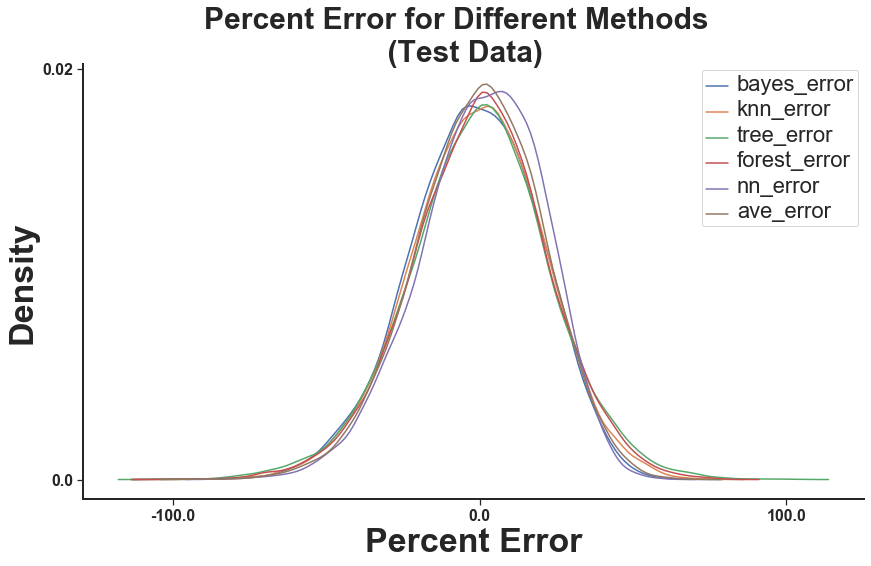

In [104]:
fig = plt.figure(figsize=(14,8))
#sns.set(style="ticks")
sns.set_style("ticks")
plt.suptitle('Percent Error for Different Methods \n (Test Data)',
              fontsize=30, fontweight='bold')

for method in methods:
    ax = sns.kdeplot(df_results[method+'_error'], shade=False)

sns.despine();
improve_plot(ax, 'Percent Error', 'Density', nxticks=5)

plt.setp(ax.get_legend().get_texts(), fontsize='22')

##output for inclusion in the write up   
ax.figure.savefig('./errors_by_method')

# Make a series of plots for each method  
- Plot 1 is the distribution of the percent error including 'rug' values
- Plot 2 is a plot of predicted salary (y_hat_*method*) vs. ground truth (y_truth)
- Plot 3 is a residual plot
- These plots used in Figure x of the associated write up

bayes MODEL
mean percent error:  1.230775945960673
rmse:  21.164794711169773  scatter index:  0.18250157032349762
mean absolute error:  16.92771919304831


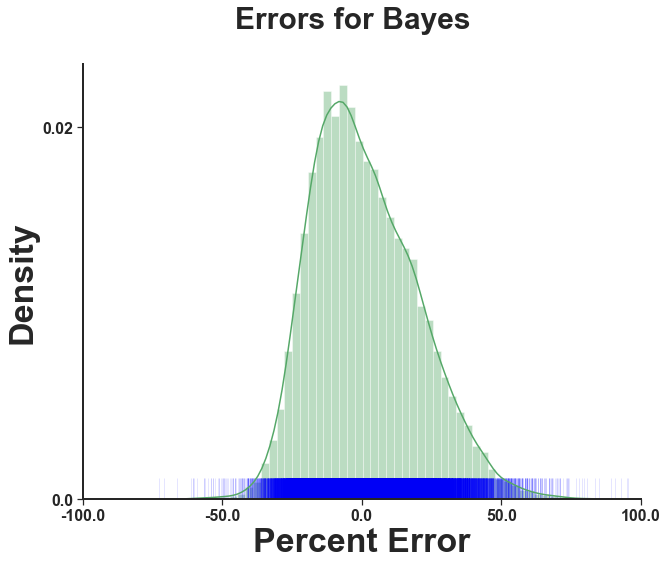

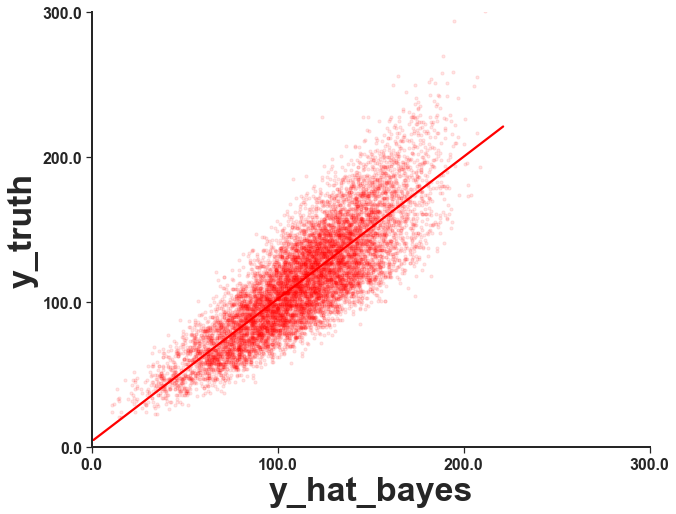

correlation [[1.         0.83920123]
 [0.83920123 1.        ]]


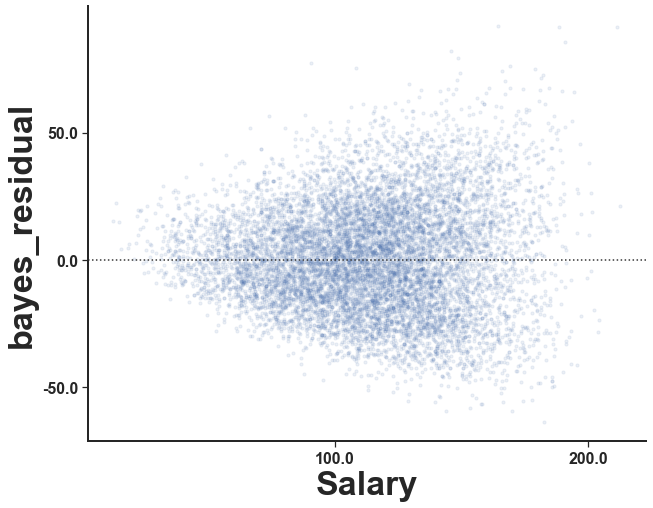

knn MODEL
mean percent error:  2.2189511574413148
rmse:  21.807680573596084  scatter index:  0.1880451005600398
mean absolute error:  17.32426


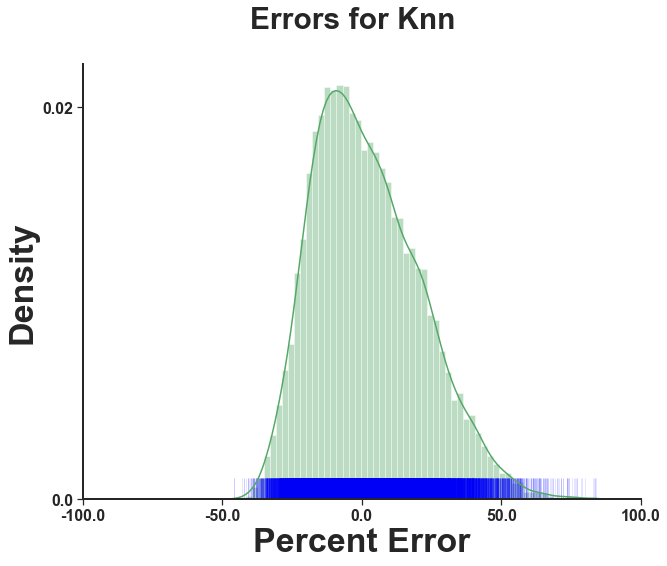

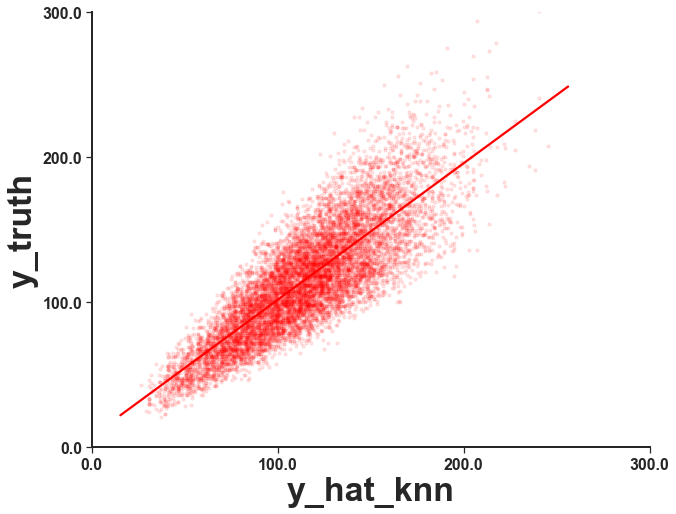

correlation [[1.         0.82870295]
 [0.82870295 1.        ]]


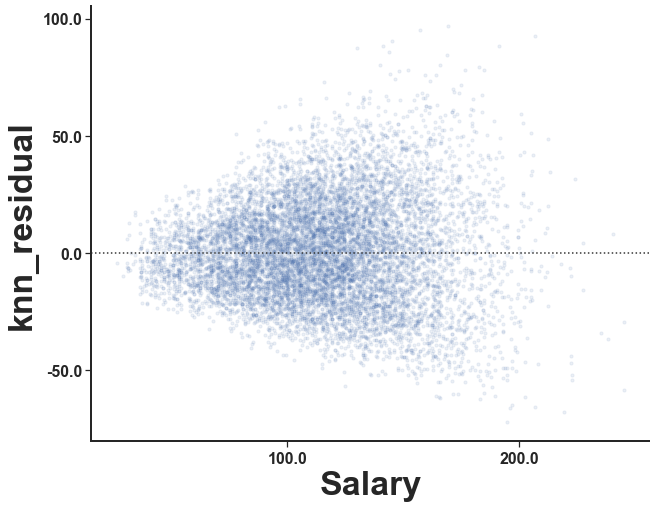

tree MODEL
mean percent error:  2.770477771258208
rmse:  23.36332349493187  scatter index:  0.20145922906356747
mean absolute error:  18.20159592606392


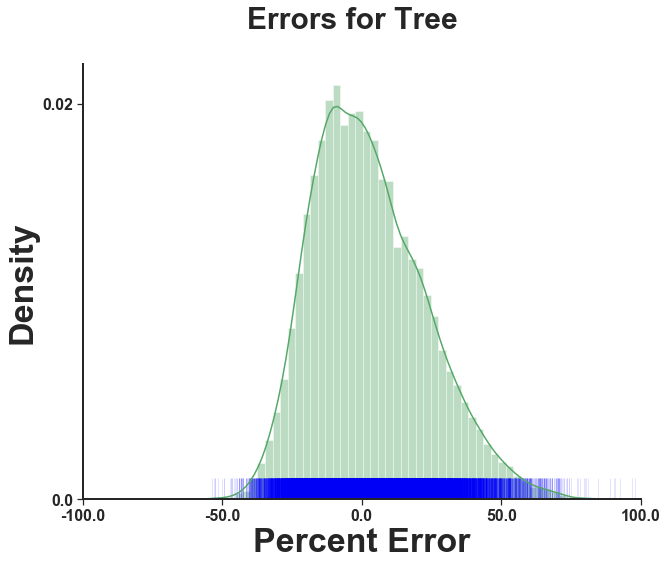

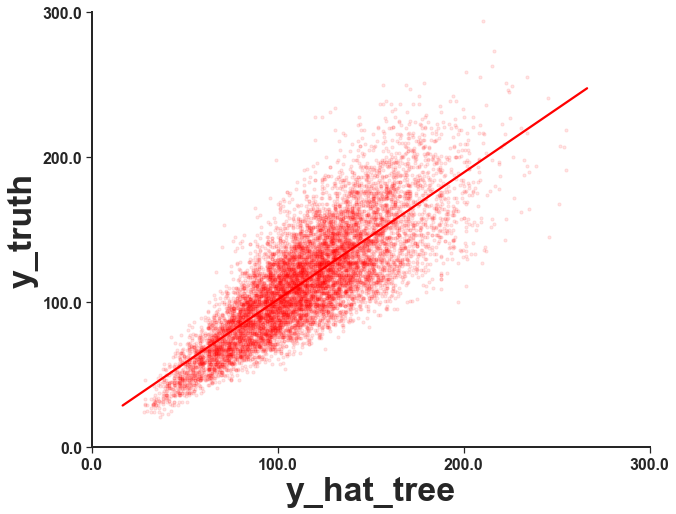

correlation [[1.        0.8057003]
 [0.8057003 1.       ]]


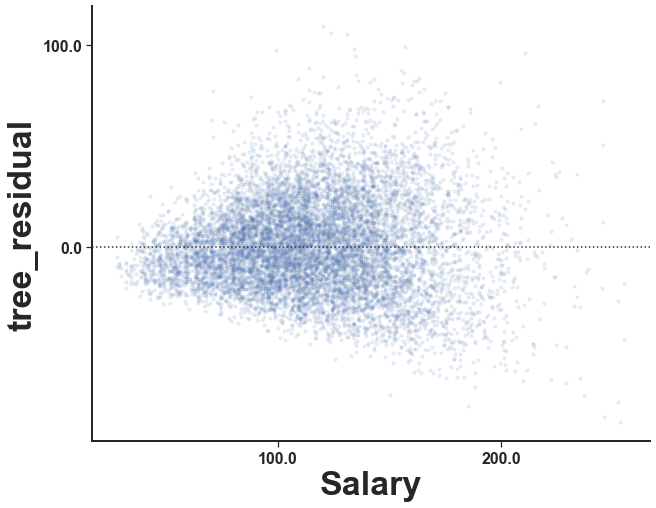

forest MODEL
mean percent error:  2.869889273142033
rmse:  22.30427341791017  scatter index:  0.19232716306693023
mean absolute error:  17.535147969384766


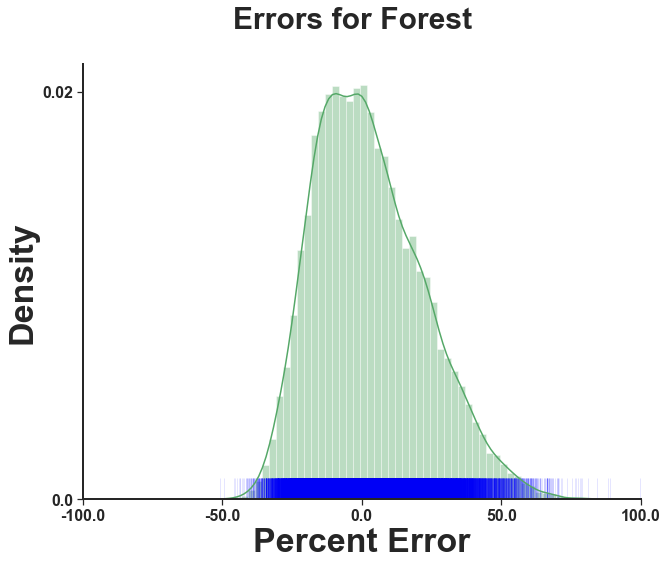

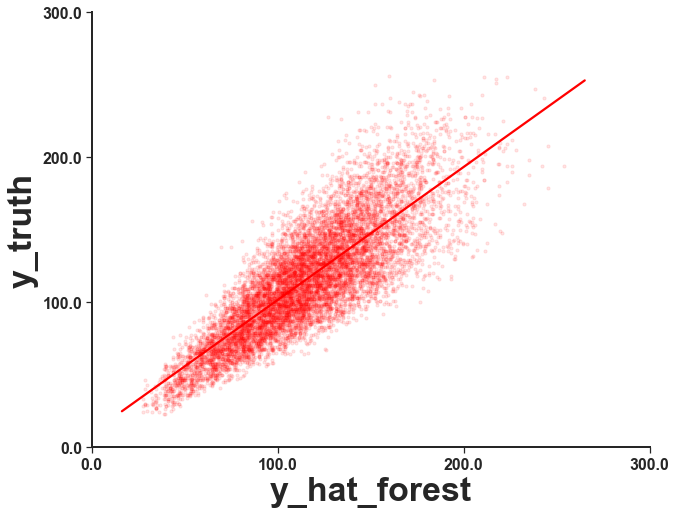

correlation [[1.        0.8216152]
 [0.8216152 1.       ]]


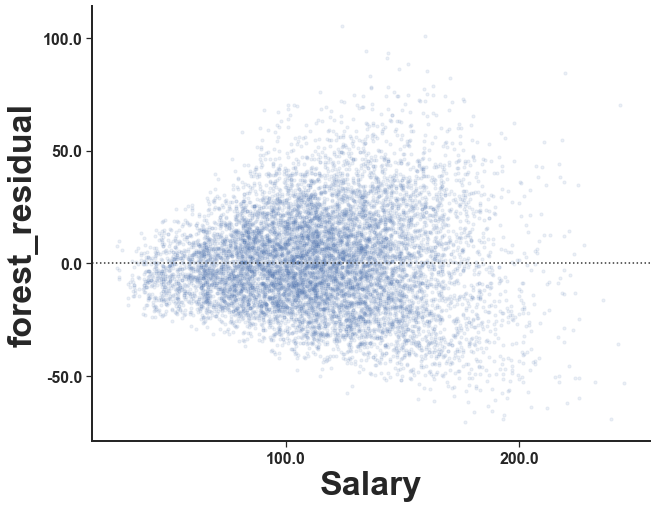

nn MODEL
mean percent error:  4.503321620804148
rmse:  20.089817652264014  scatter index:  0.17323216780911843
mean absolute error:  16.180994015693663


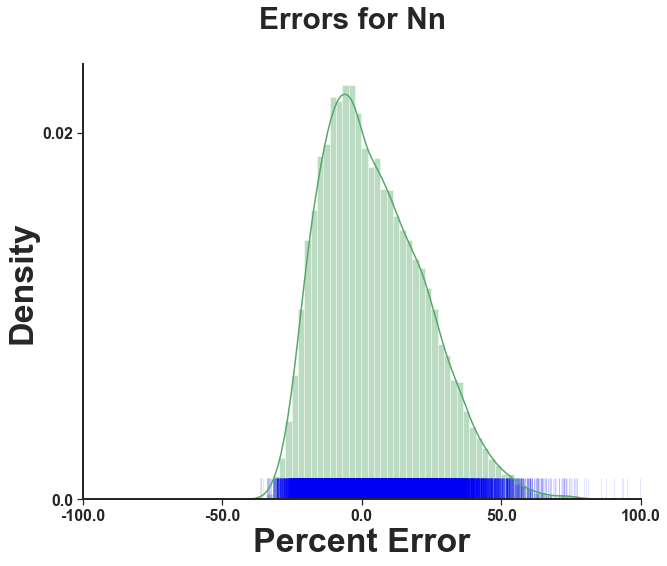

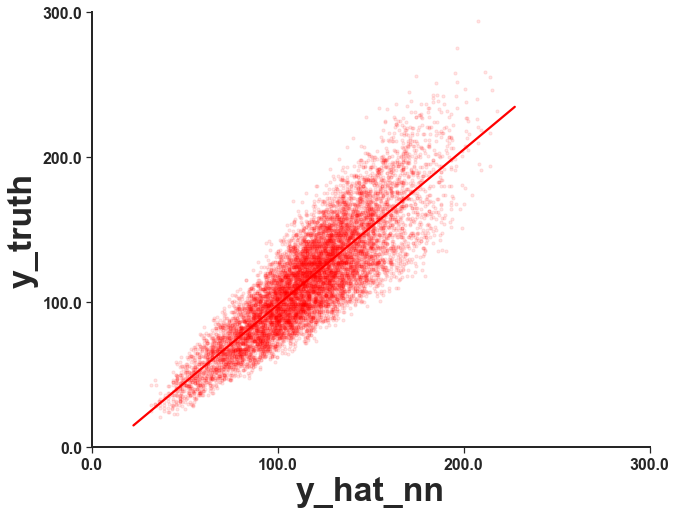

correlation [[1.         0.85748262]
 [0.85748262 1.        ]]


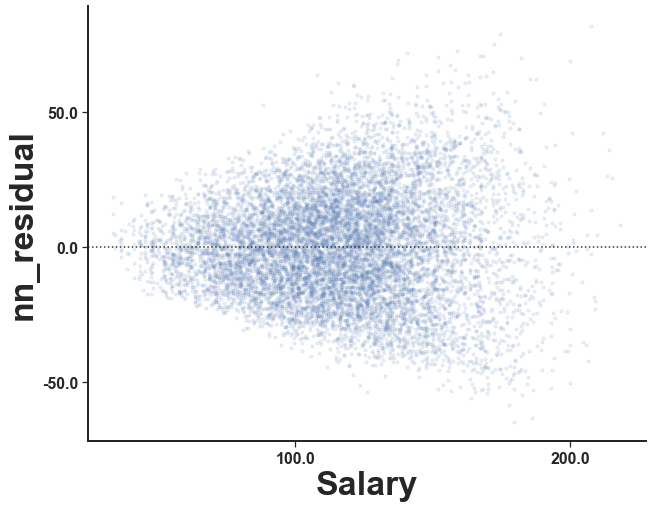

ave MODEL
mean percent error:  2.7186831537212757
rmse:  20.661311703382832  scatter index:  0.17816009473602967
mean absolute error:  16.46223267948326


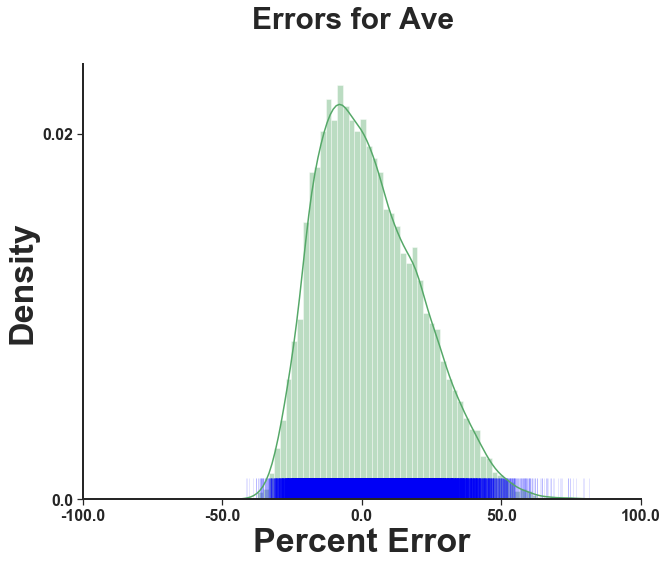

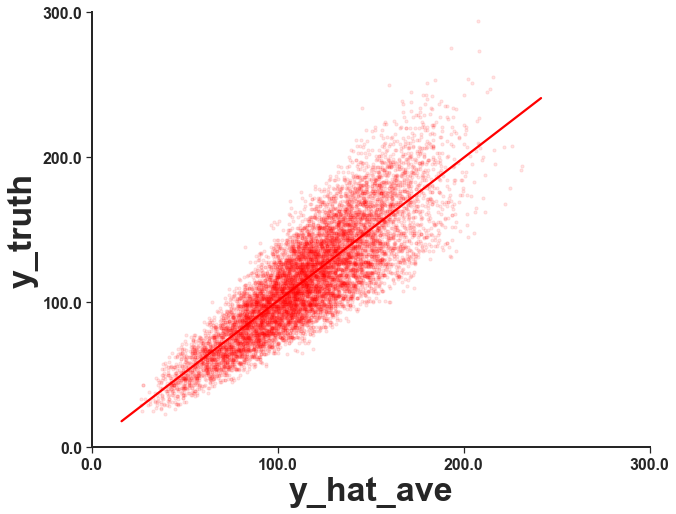

correlation [[1.         0.84615811]
 [0.84615811 1.        ]]


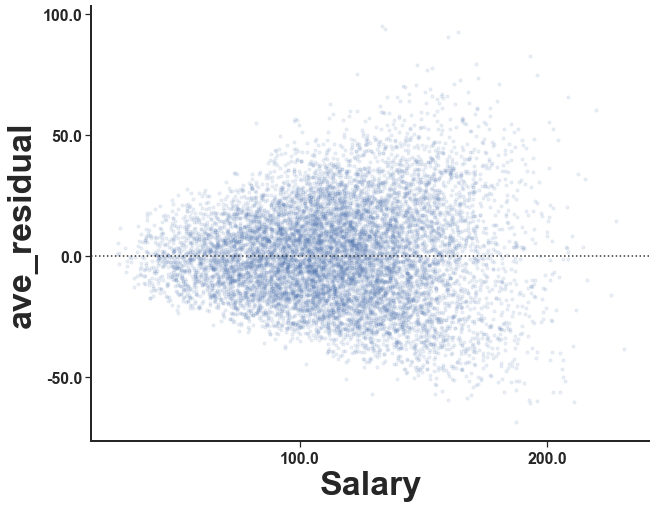

In [105]:
def plot_predictions(df_results, method, salary_mean, nsamples):

    fig = plt.figure(figsize=(10,8))
    rmse = np.sqrt(np.sum(np.power(df_results[method+'_error'],2))/len(df_results))
    print(method + " MODEL")
    print("mean percent error: ", np.mean(df_results[method+'_percent_error']))
    print("rmse: ", rmse, " scatter index: ", rmse/salary_mean)
    print("mean absolute error: ", np.mean(np.abs(df_results[method+'_error'])))

    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    plt.suptitle('Errors for ' + method.capitalize(),
                  fontsize=30, fontweight='bold')
    #plt.subplot(2, 1, 1)
    ax = sns.distplot(df_results[method+'_percent_error'], color="C2", 
                 rug=True, kde=True, bins=60,
                 rug_kws={"color": "blue", "alpha": .2, "linewidth": .5, "height":0.05 })
    ax.set(xlim=(-100, 100))
    sns.despine()
    
    improve_plot(ax, 'Percent Error', 'Density')
    
    plt.show()
    fig.savefig('./'+method+'_percent_error')
    
    fig = plt.figure(figsize=(10,8))


    ax = sns.regplot(x='y_hat_'+method, y='y_truth',
                fit_reg=True, data=df_results.sample(nsamples),
                color='red', ci=None, scatter_kws={'s': 10, 'alpha': .1})
    
    ax.set(xlim=(0, 300))
    ax.set(ylim=(0, 300))
    sns.despine()
    
    improve_plot(ax, ax.get_xlabel(), ax.get_ylabel(),nxticks=4, nyticks=4)
    
    plt.show()
    fig.savefig('./'+method+'_correlation')

    fig = plt.figure(figsize=(10,8))
    print("correlation", np.corrcoef(df_results['y_hat_'+method], df_results['y_truth']))
    
    ax = sns.residplot(x="y_hat_"+method, y="y_truth", robust=True, data=df_results.sample(nsamples),
                  scatter_kws={"s": 10, "alpha": .1}, line_kws={"lw": 5});
    
    sns.despine()
    improve_plot(ax, 'Salary', method+'_residual', nxticks=4, nyticks=4)
    
    fig.savefig('./'+method+'_residual')
    plt.show()

    
##run the function for each method
for method in methods:
    plot_predictions(df_results, method, np.mean(df_validation.salary), 10000)

# Make Bayesian credible plots showing predictions of different methods

<class 'numpy.ndarray'>


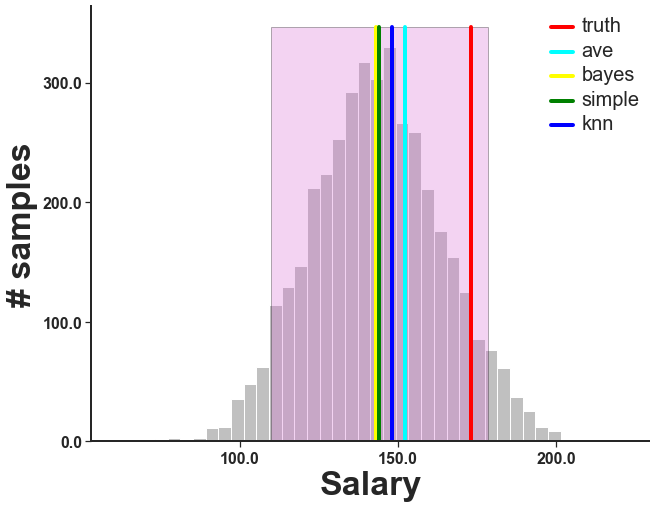

<class 'numpy.ndarray'>


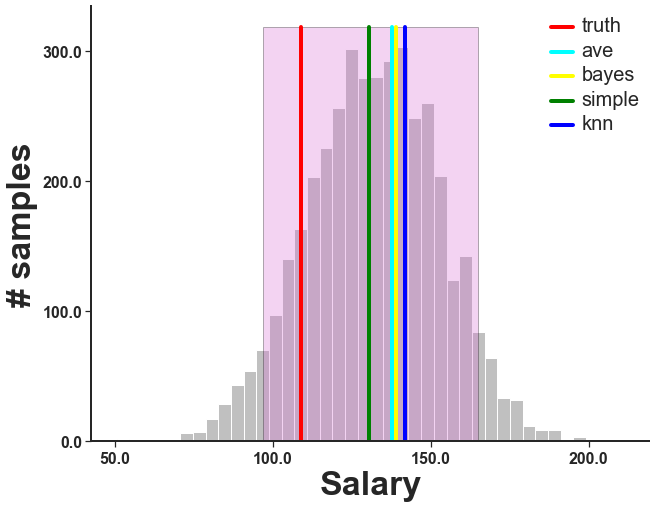

<class 'numpy.ndarray'>


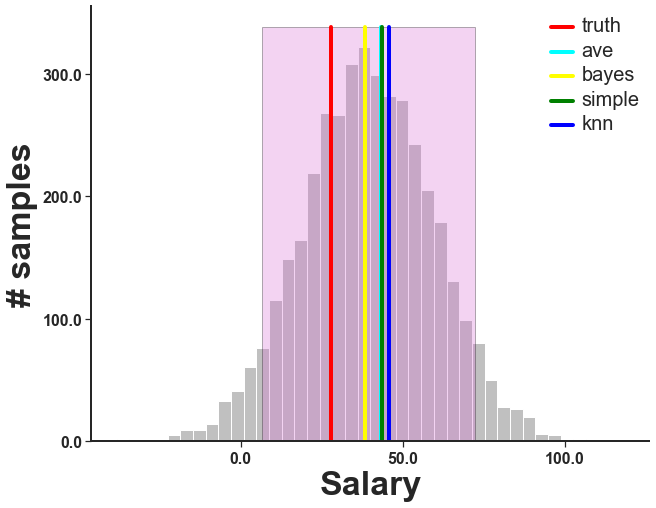

<class 'numpy.ndarray'>


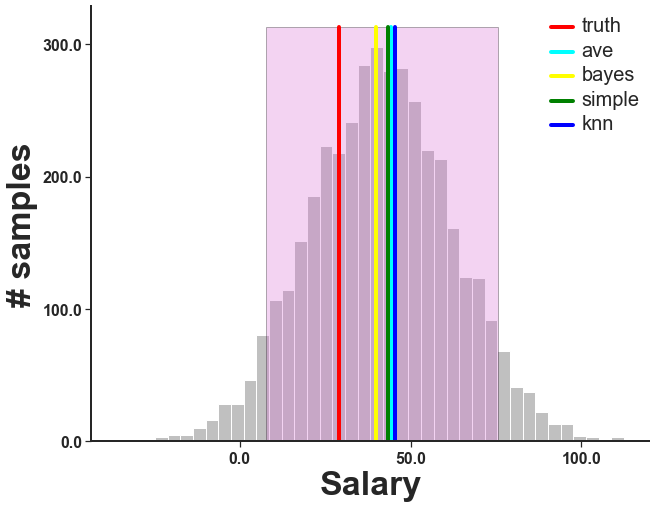

<class 'numpy.ndarray'>


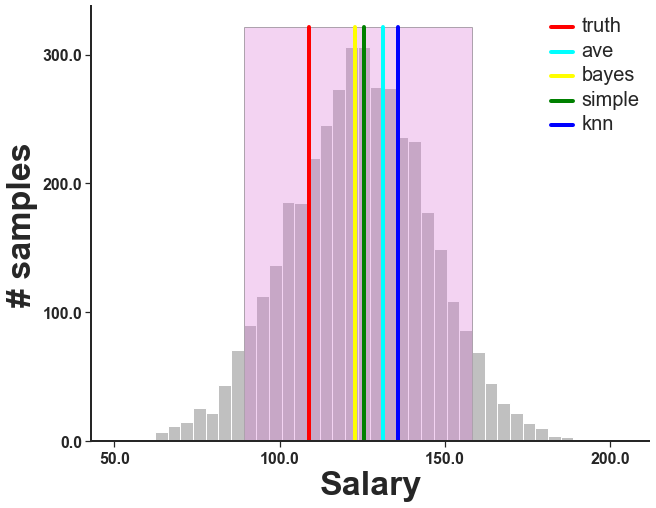

<class 'numpy.ndarray'>


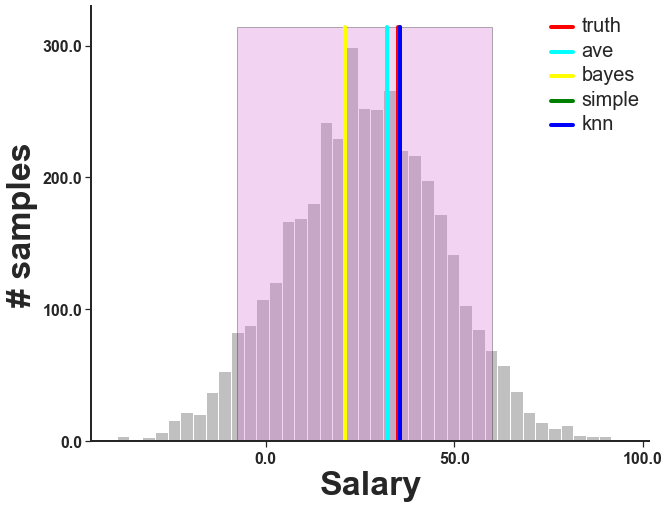

<class 'numpy.ndarray'>


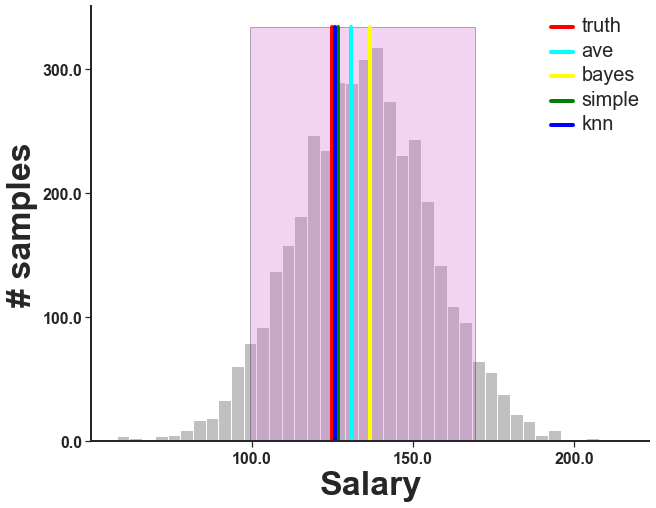

<class 'numpy.ndarray'>


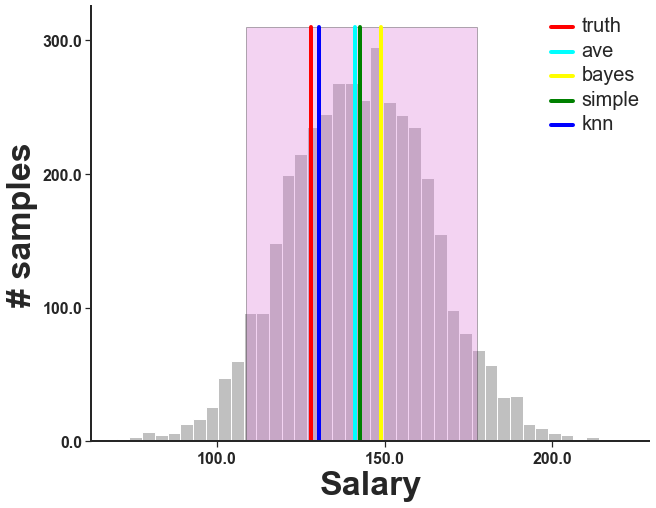

<class 'numpy.ndarray'>


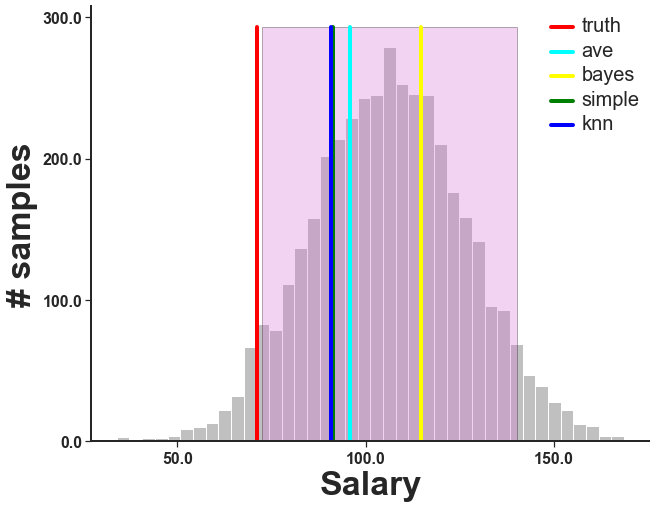

<class 'numpy.ndarray'>


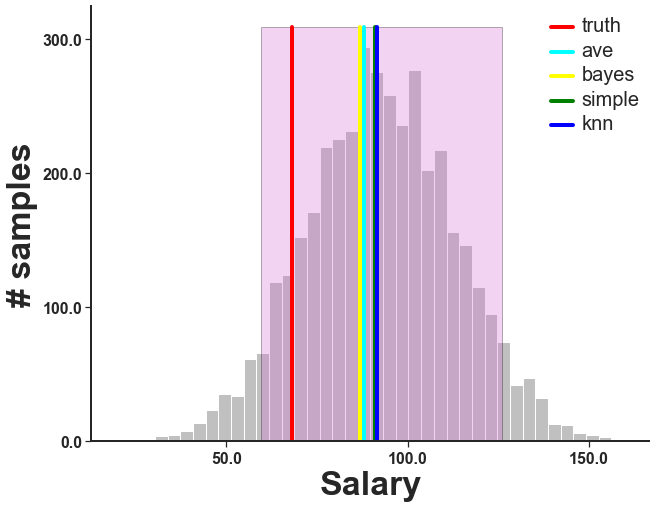

<class 'numpy.ndarray'>


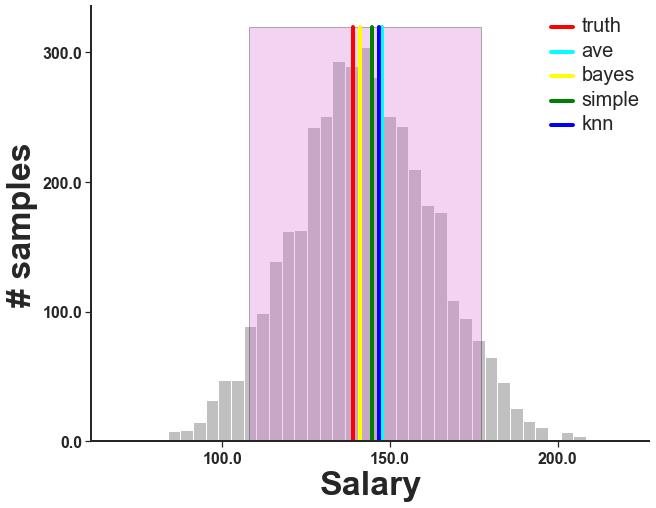

<class 'numpy.ndarray'>


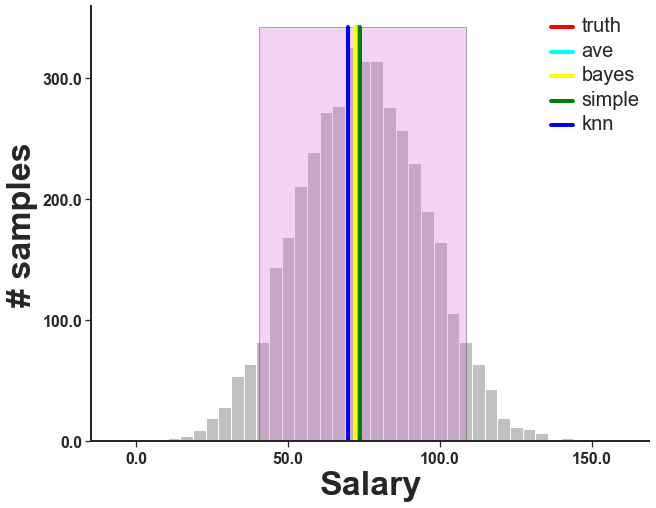

<class 'numpy.ndarray'>


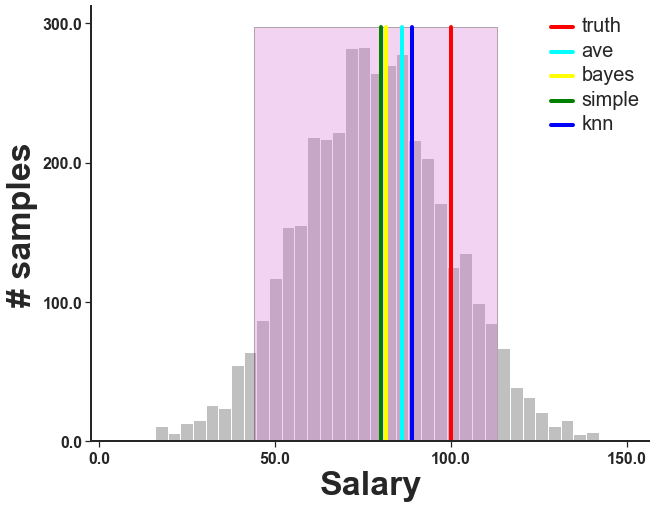

<class 'numpy.ndarray'>


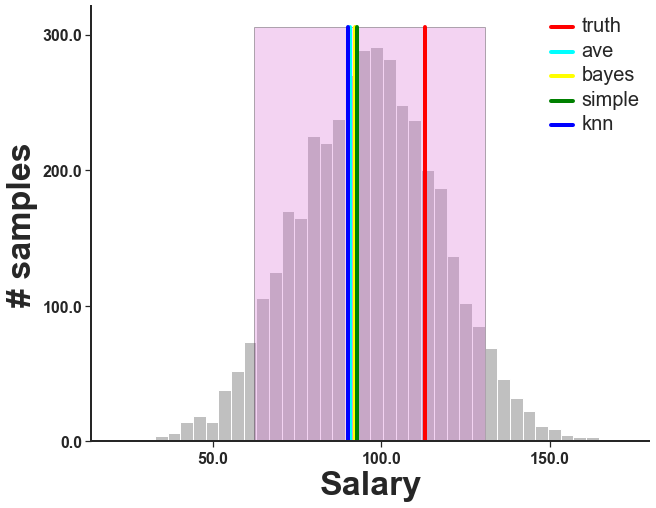

<class 'numpy.ndarray'>


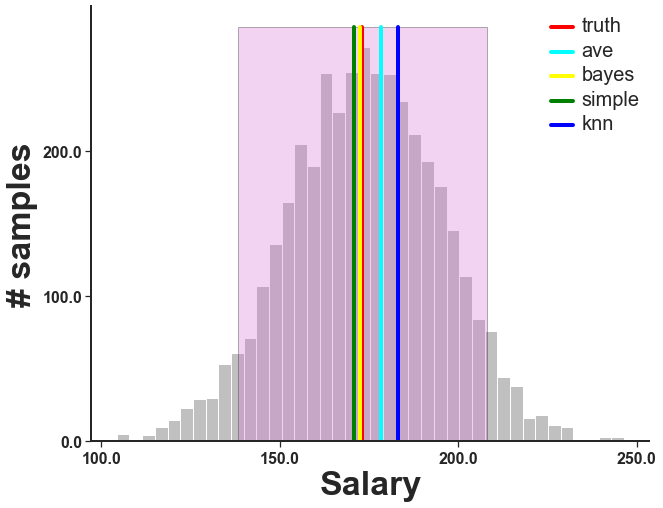

<class 'numpy.ndarray'>


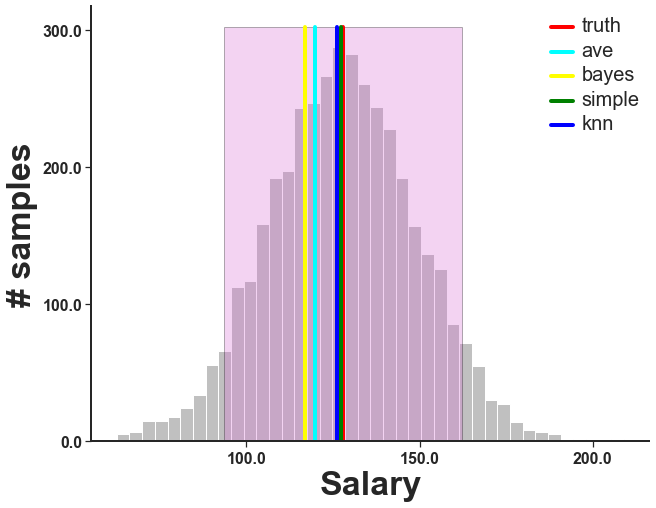

<class 'numpy.ndarray'>


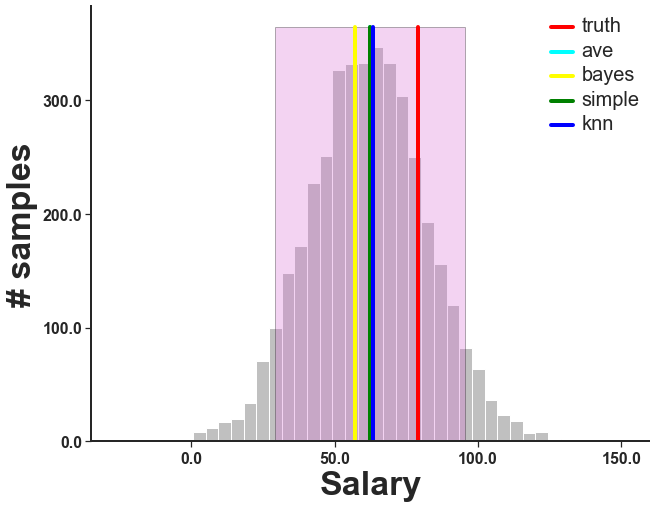

<class 'numpy.ndarray'>


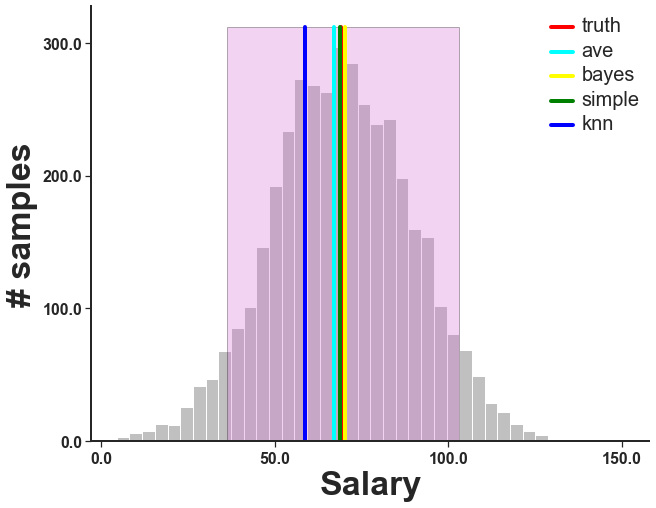

<class 'numpy.ndarray'>


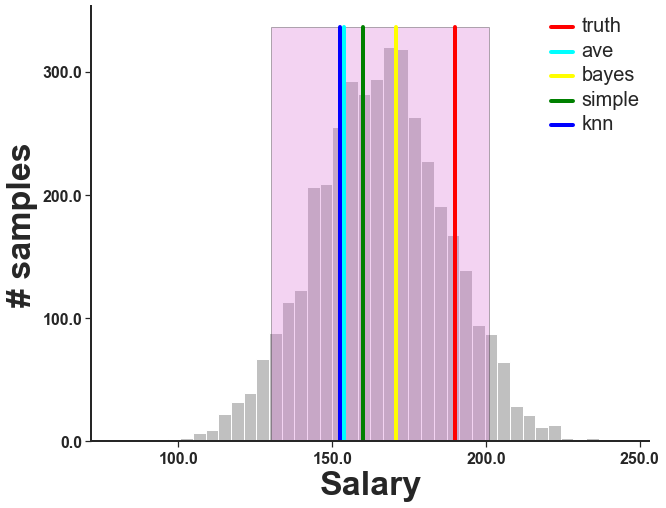

<class 'numpy.ndarray'>


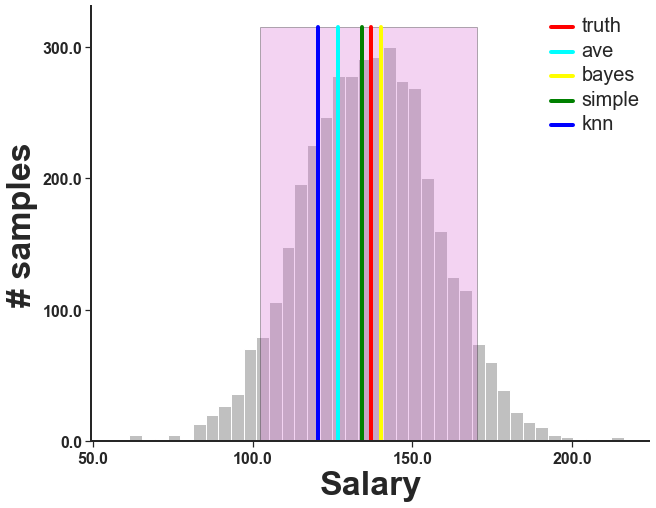

<class 'numpy.ndarray'>


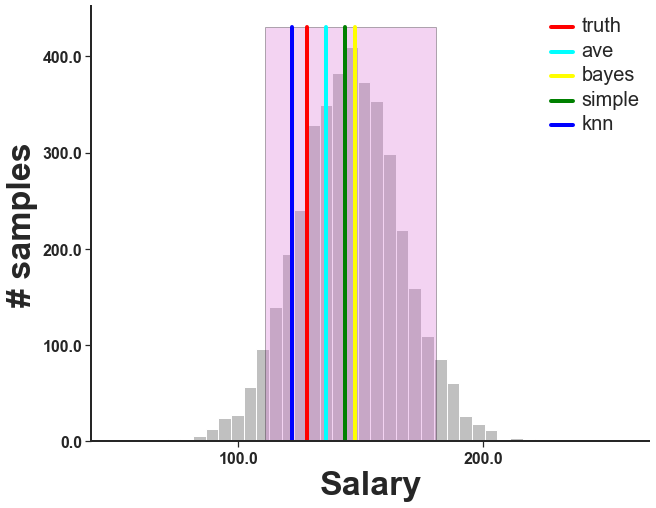

<class 'numpy.ndarray'>


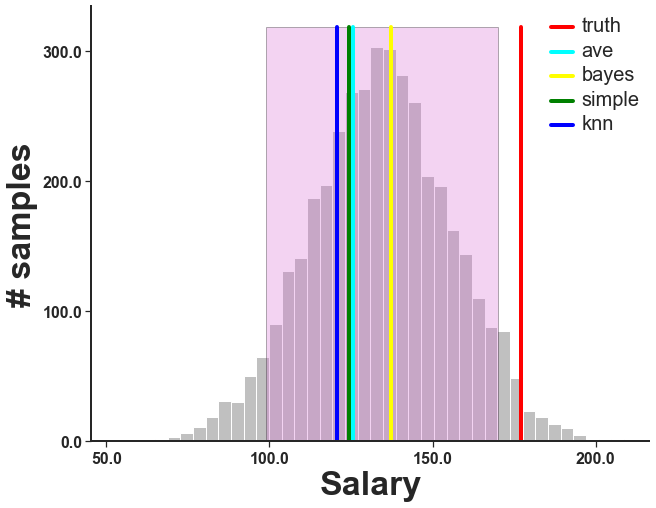

<class 'numpy.ndarray'>


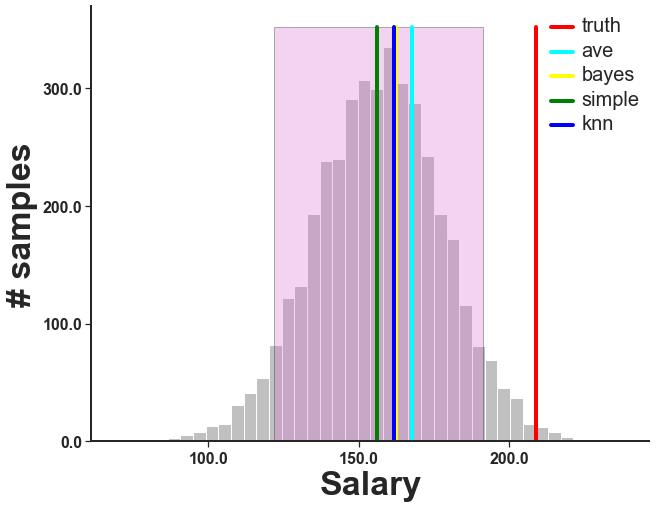

<class 'numpy.ndarray'>


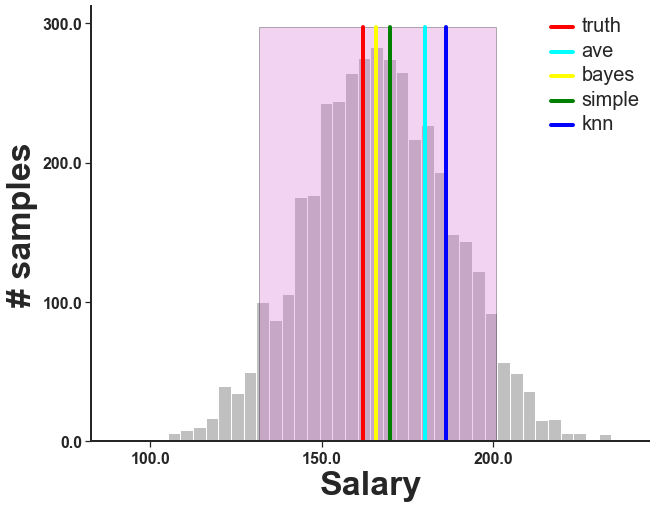

<class 'numpy.ndarray'>


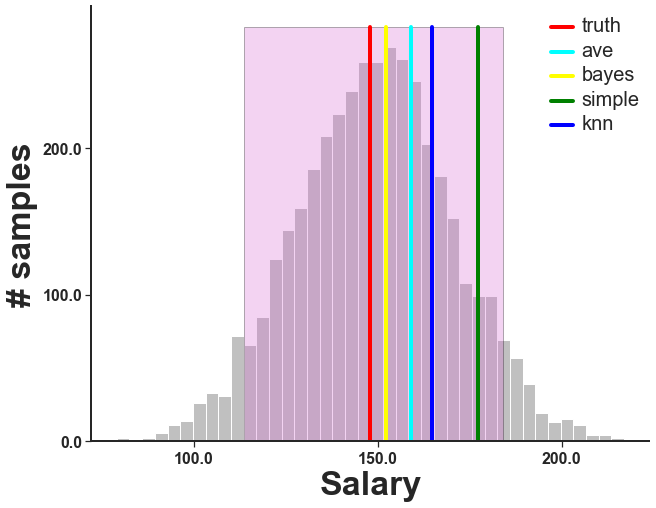

<class 'numpy.ndarray'>


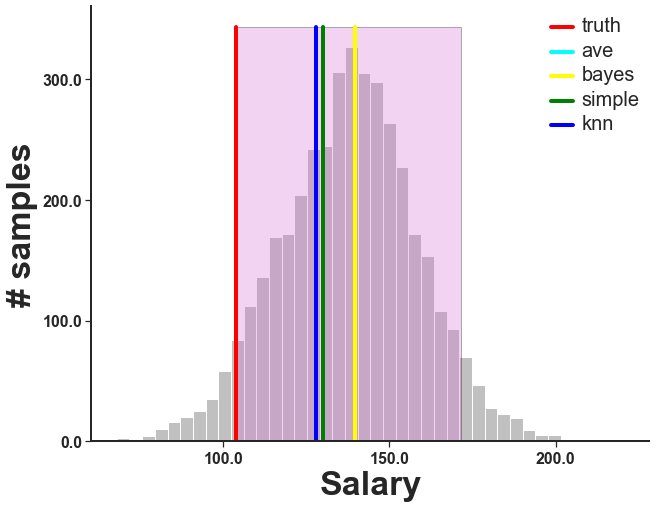

<class 'numpy.ndarray'>


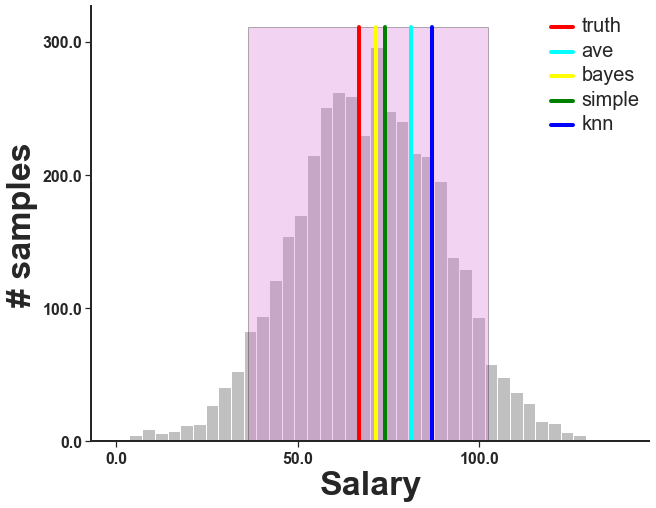

<class 'numpy.ndarray'>


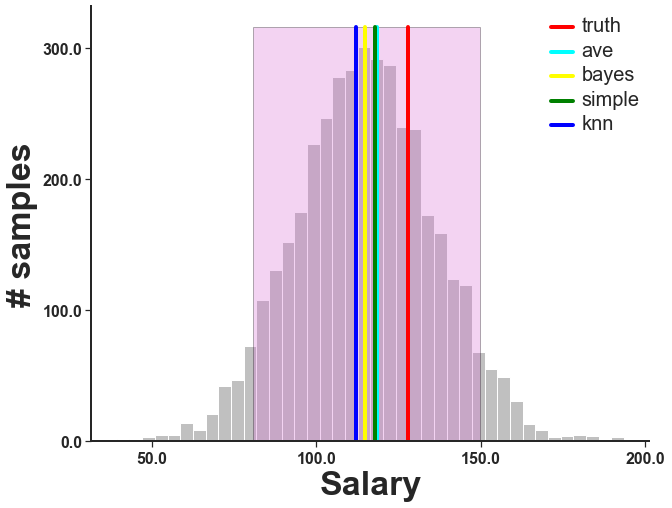

<class 'numpy.ndarray'>


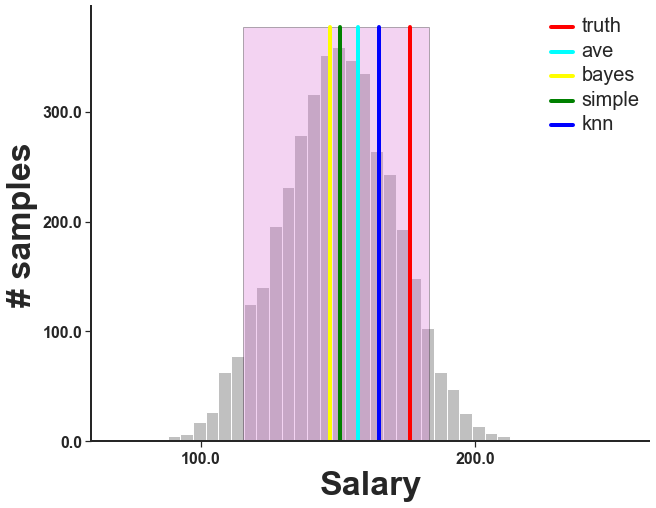

<class 'numpy.ndarray'>


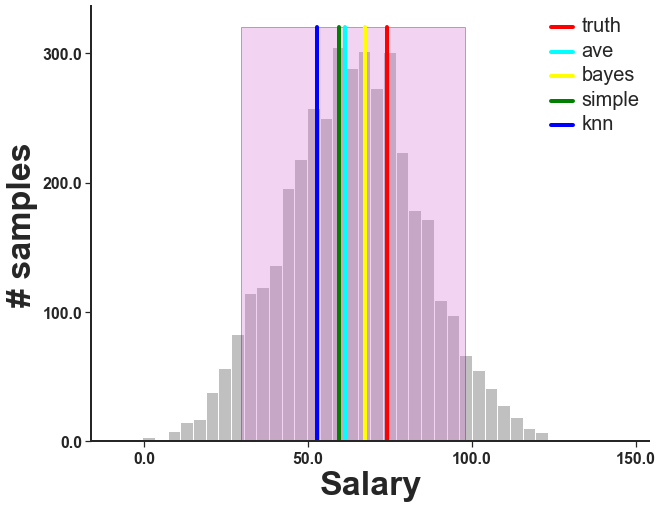

<class 'numpy.ndarray'>


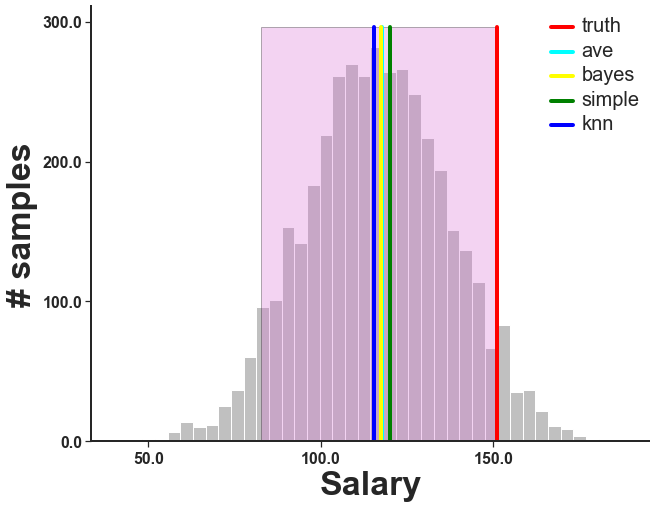

<class 'numpy.ndarray'>


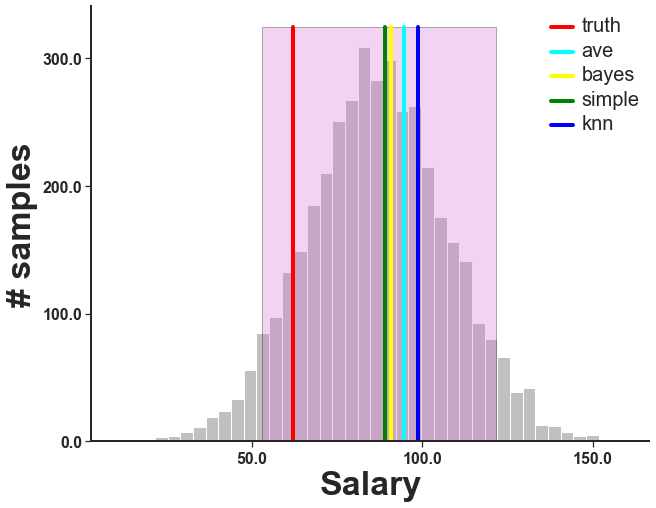

<class 'numpy.ndarray'>


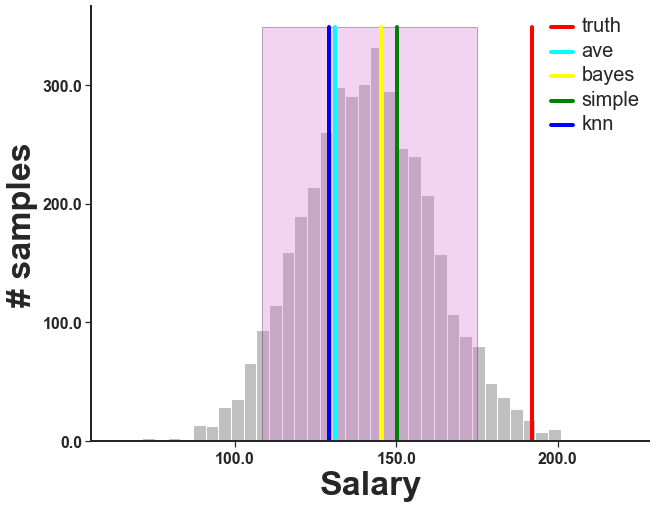

<class 'numpy.ndarray'>


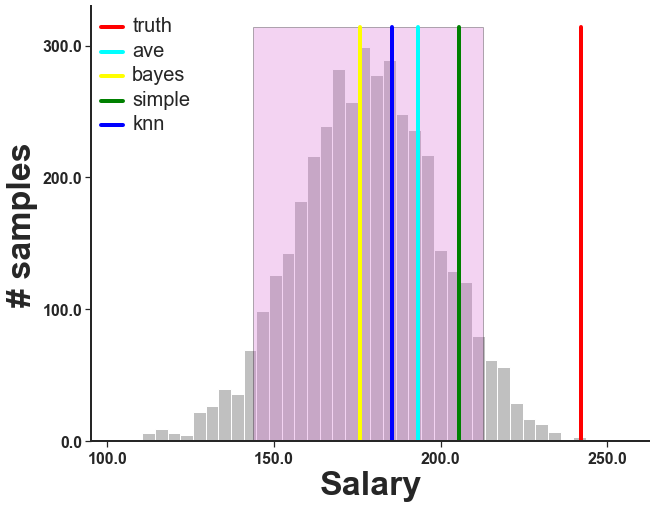

<class 'numpy.ndarray'>


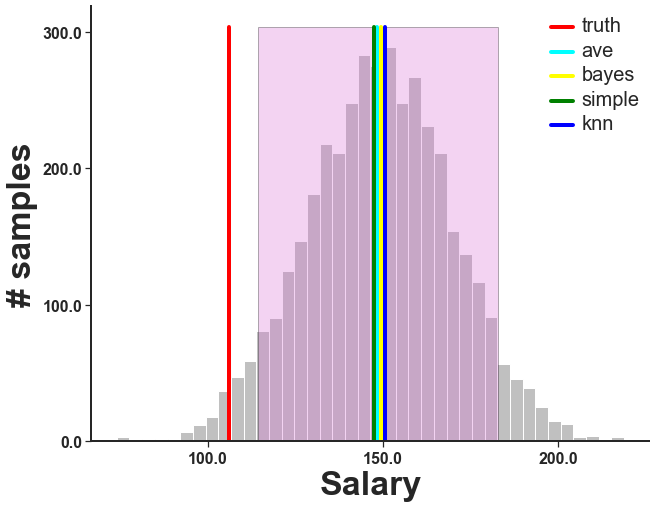

<class 'numpy.ndarray'>


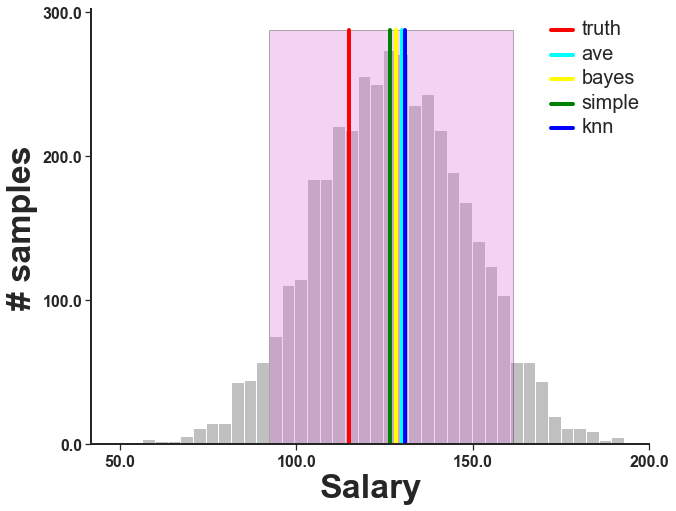

<class 'numpy.ndarray'>


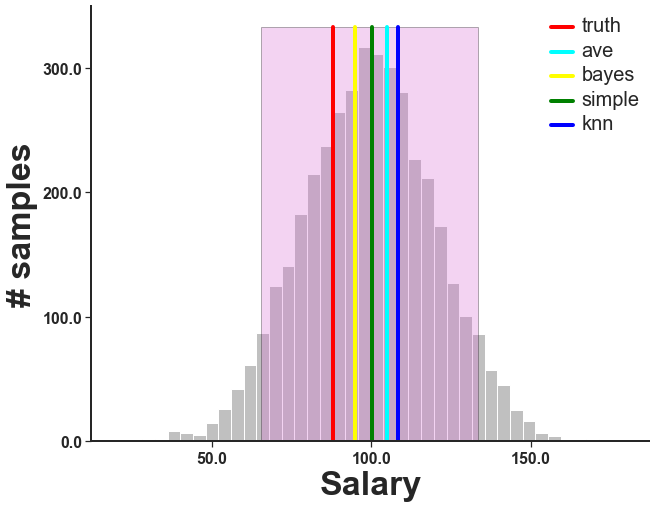

<class 'numpy.ndarray'>


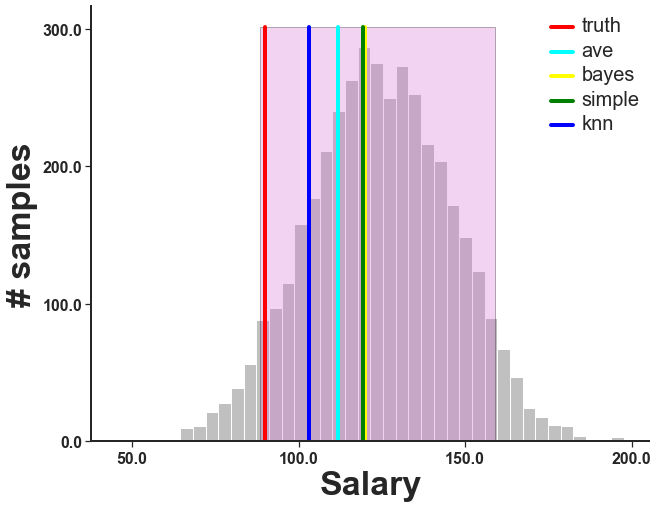

<class 'numpy.ndarray'>


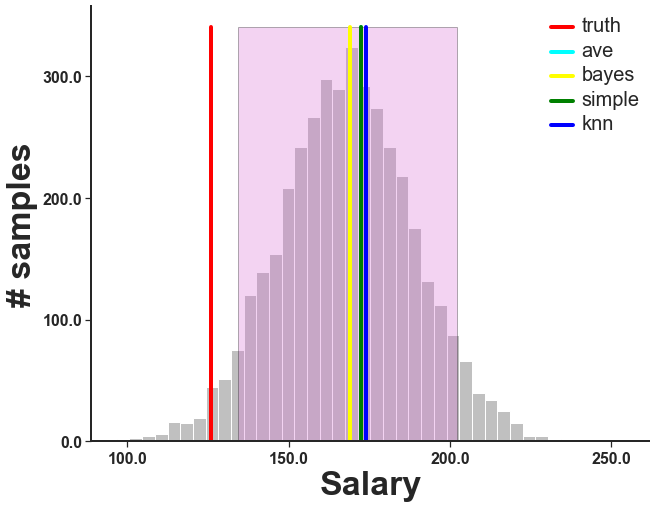

<class 'numpy.ndarray'>


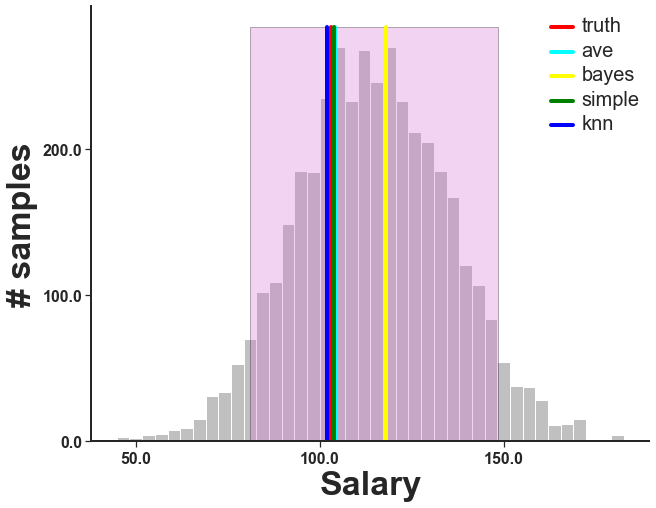

<class 'numpy.ndarray'>


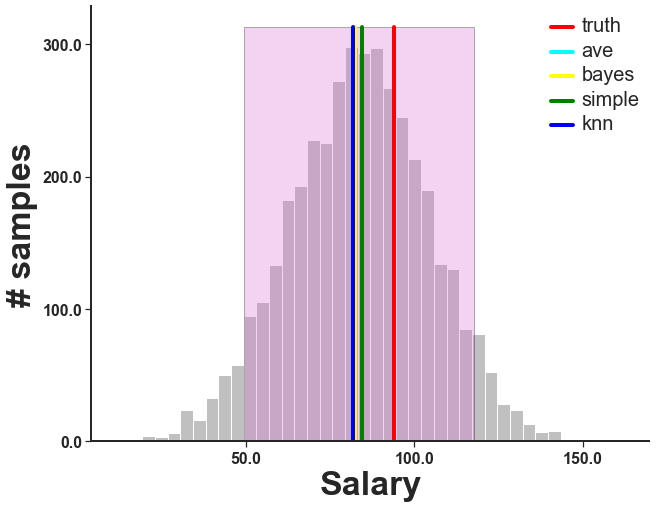

<class 'numpy.ndarray'>


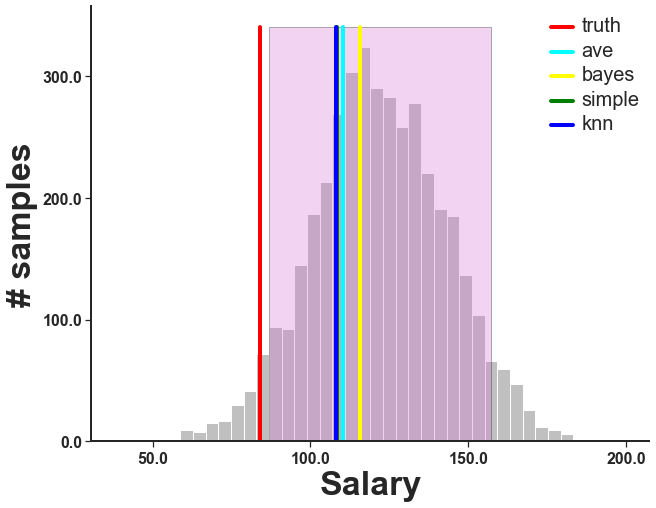

<class 'numpy.ndarray'>


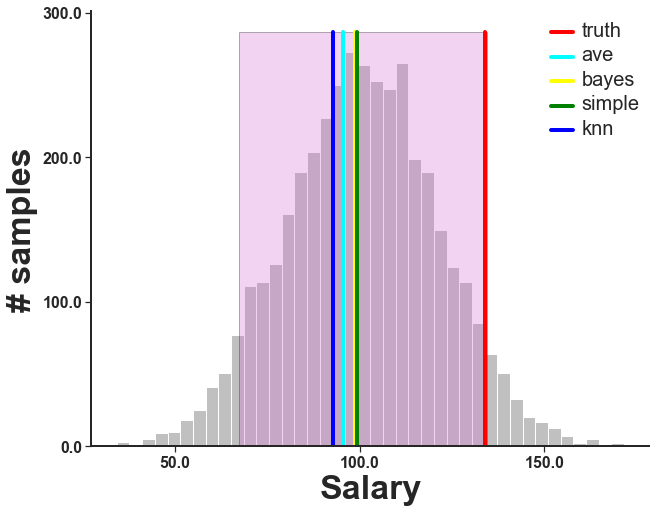

<class 'numpy.ndarray'>


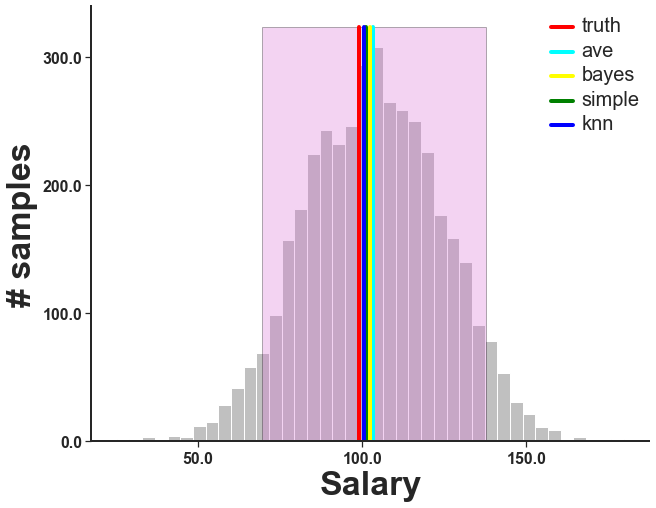

<class 'numpy.ndarray'>


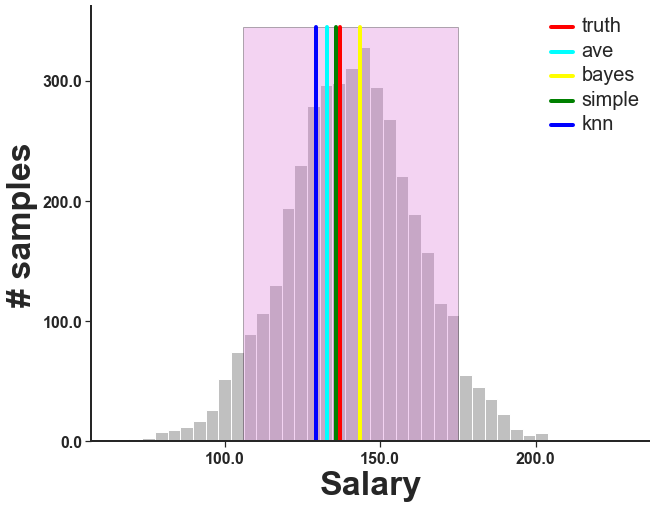

<class 'numpy.ndarray'>


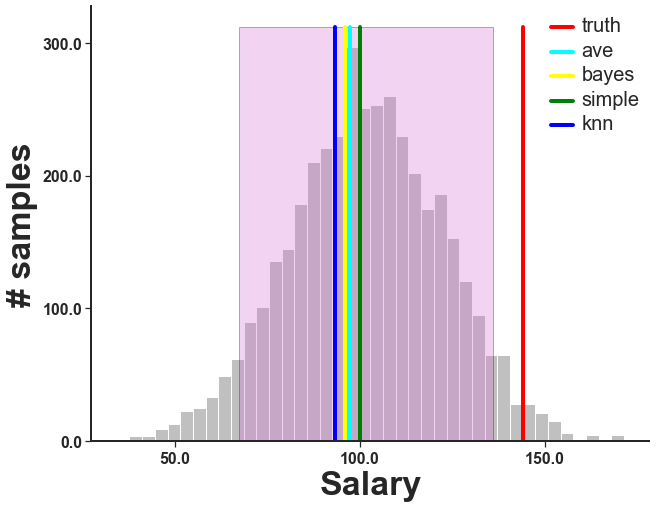

<class 'numpy.ndarray'>


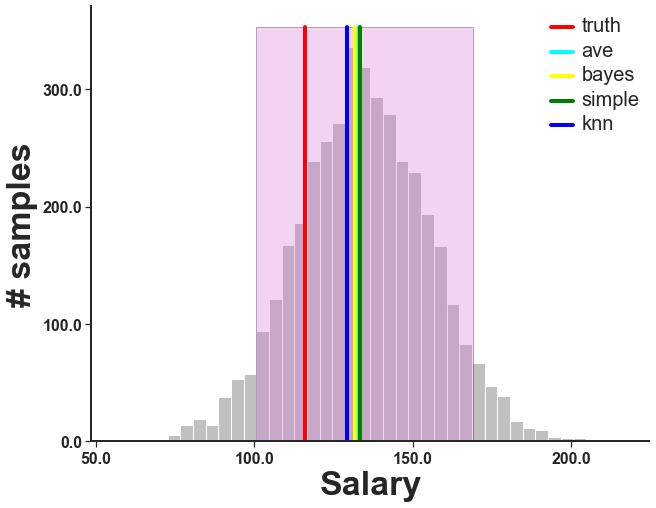

<class 'numpy.ndarray'>


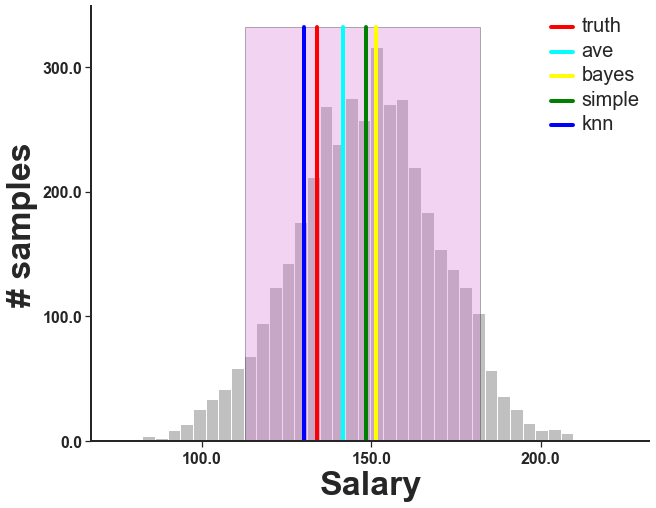

<class 'numpy.ndarray'>


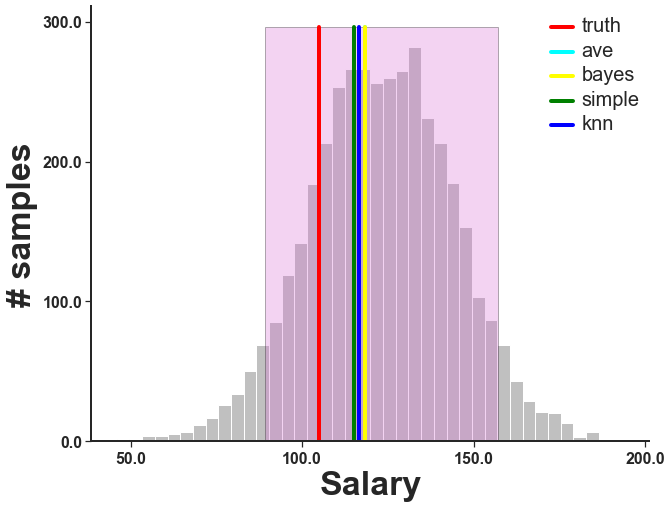

<class 'numpy.ndarray'>


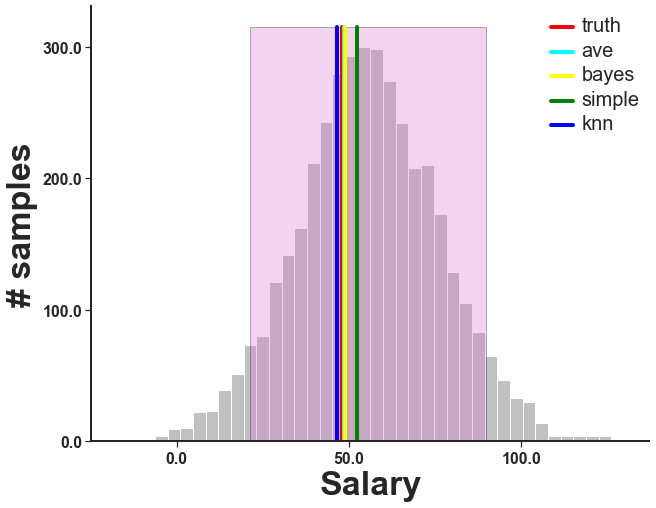

<class 'numpy.ndarray'>


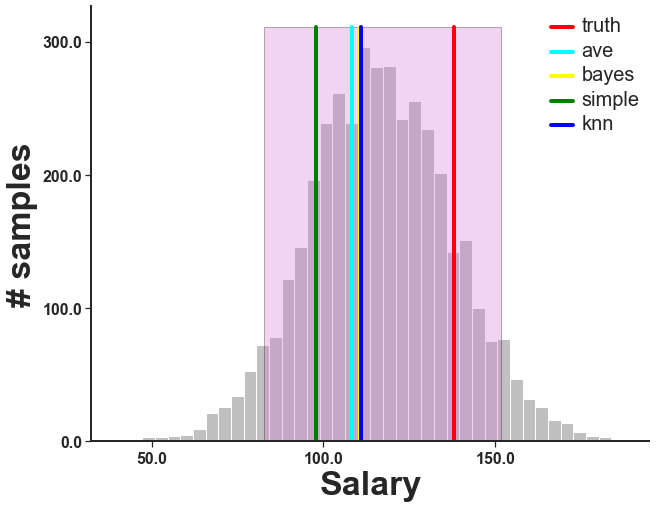

<class 'numpy.ndarray'>


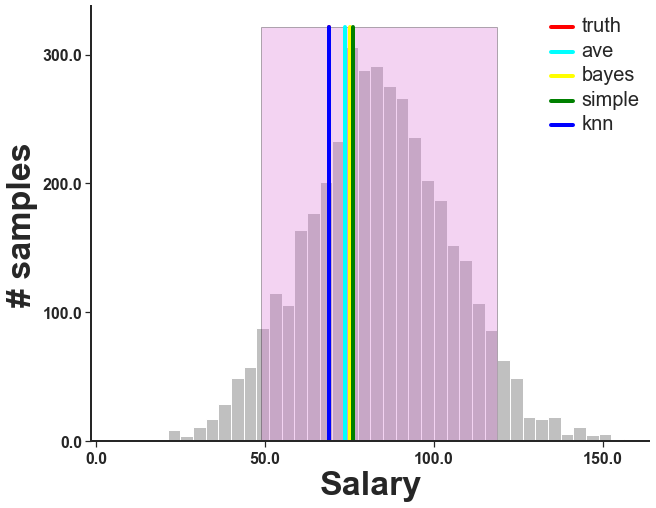

<class 'numpy.ndarray'>


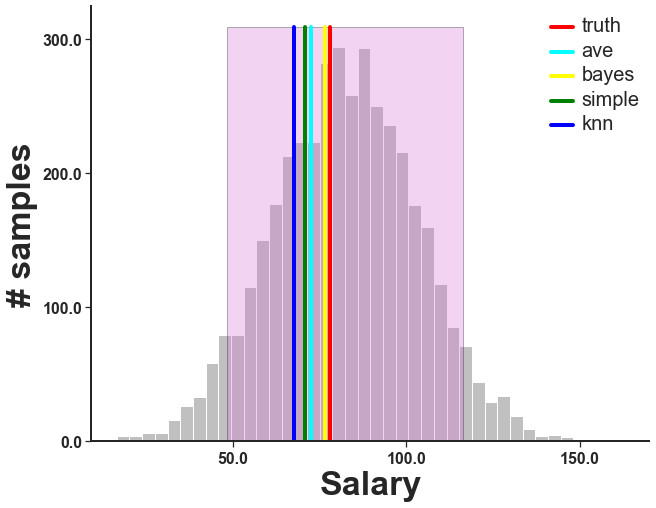

<class 'numpy.ndarray'>


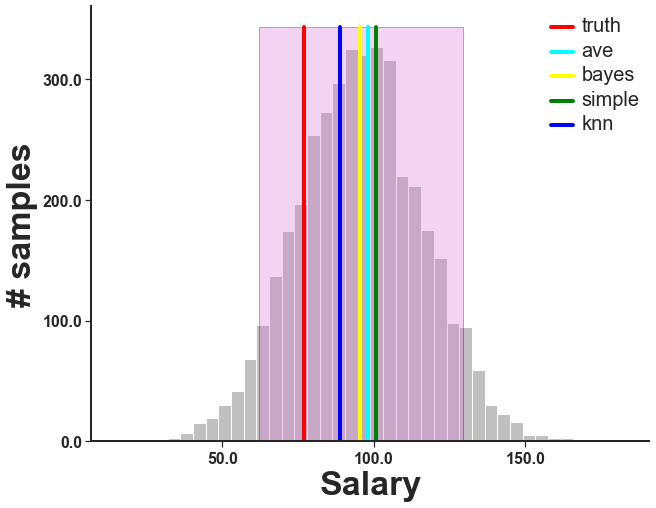

<class 'numpy.ndarray'>


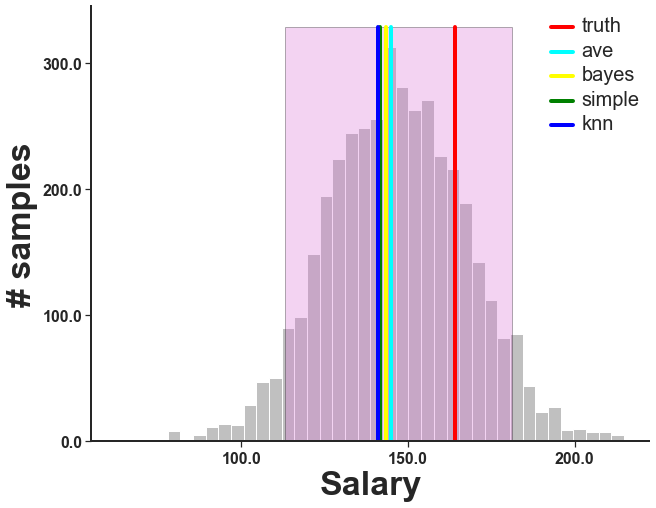

<class 'numpy.ndarray'>


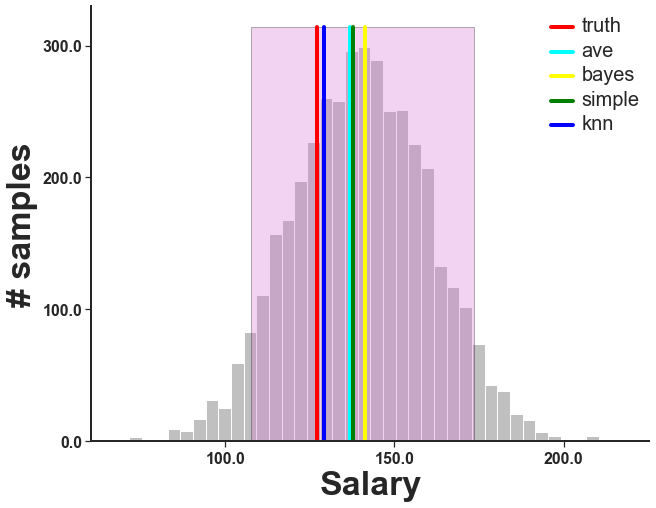

<class 'numpy.ndarray'>


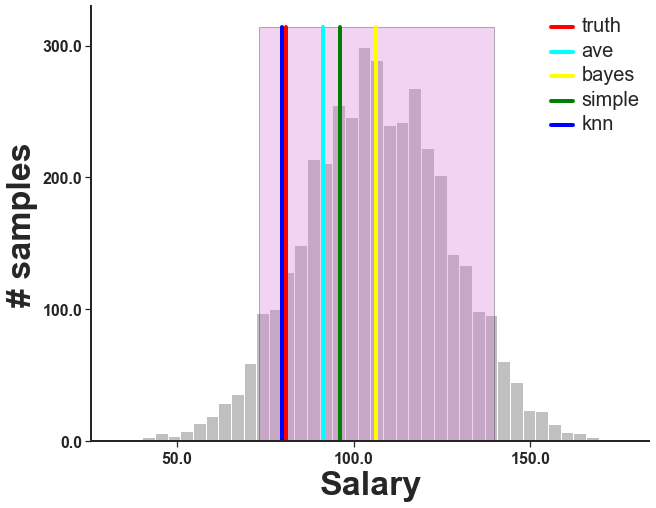

<class 'numpy.ndarray'>


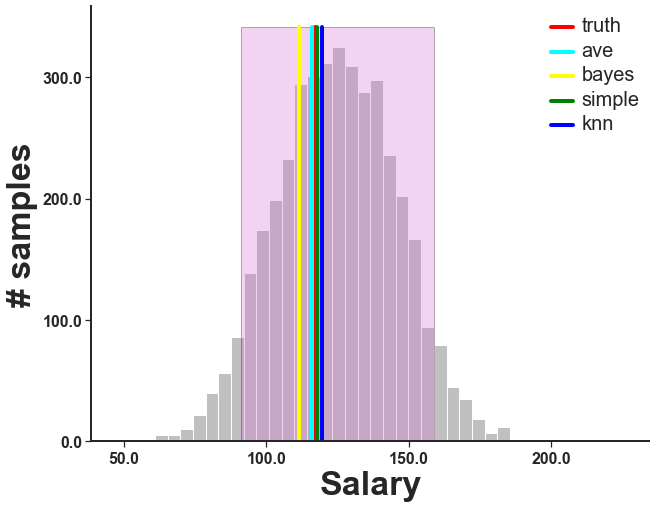

<class 'numpy.ndarray'>


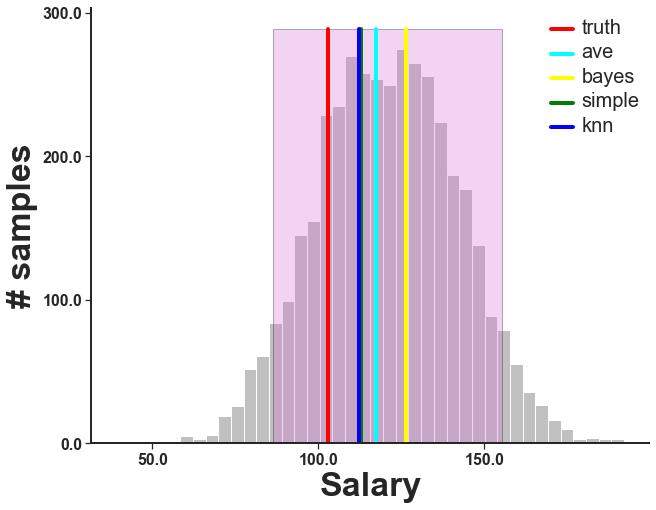

<class 'numpy.ndarray'>


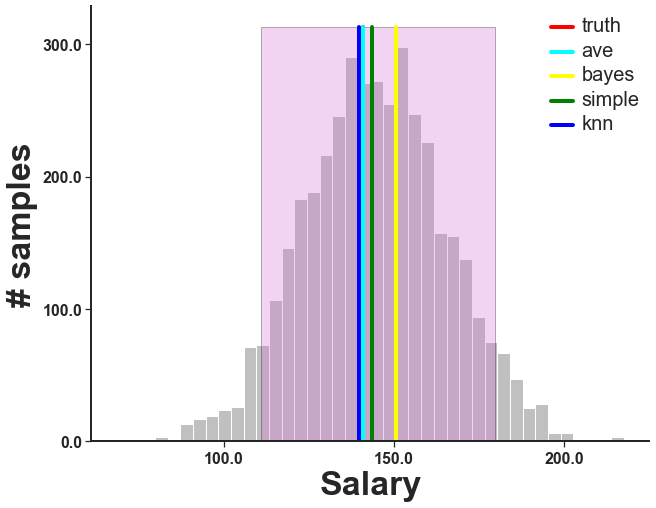

<class 'numpy.ndarray'>


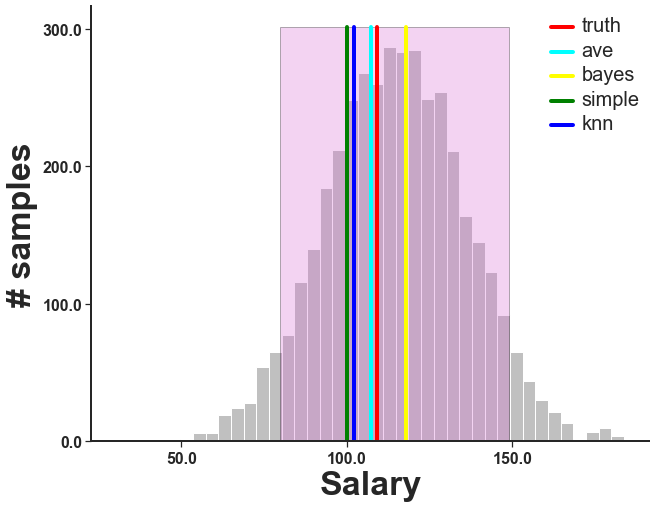

<class 'numpy.ndarray'>


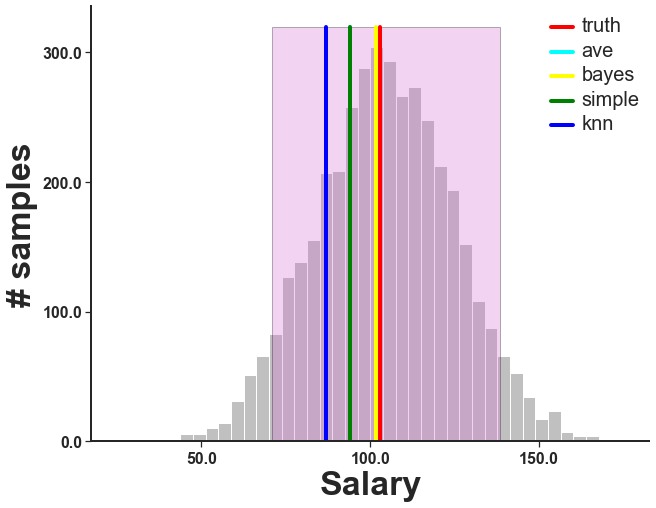

<class 'numpy.ndarray'>


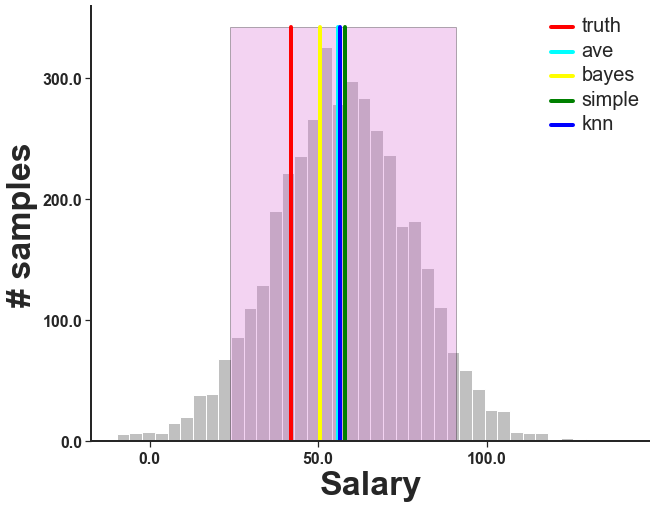

<class 'numpy.ndarray'>


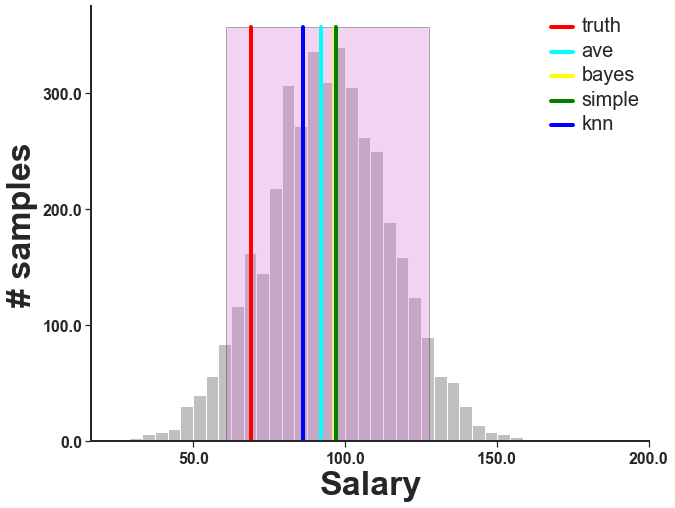

<class 'numpy.ndarray'>


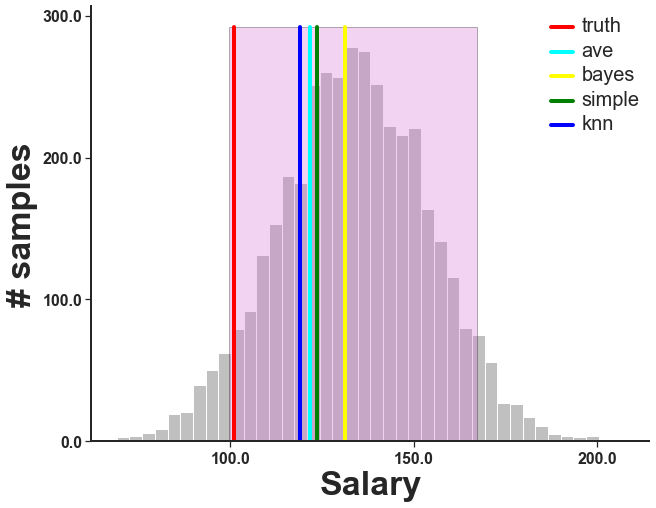

<class 'numpy.ndarray'>


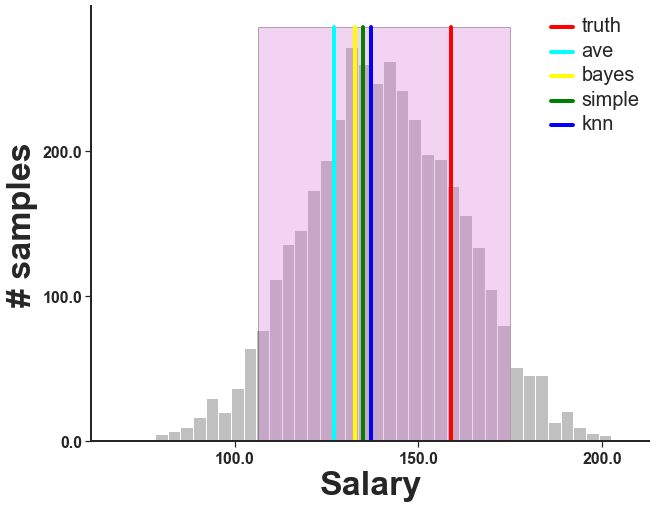

<class 'numpy.ndarray'>


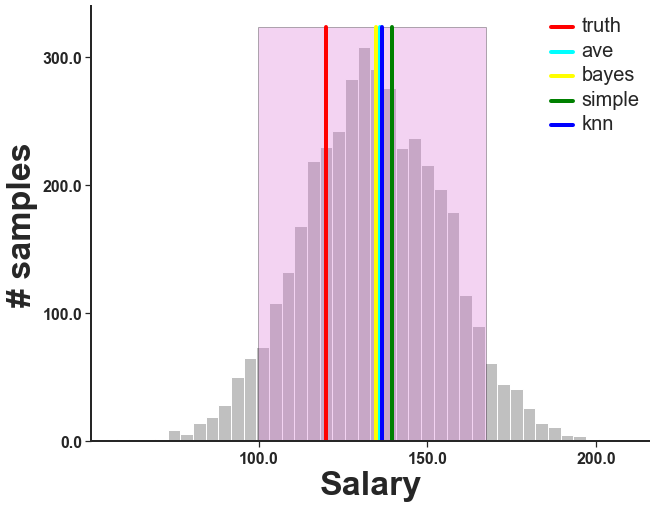

<class 'numpy.ndarray'>


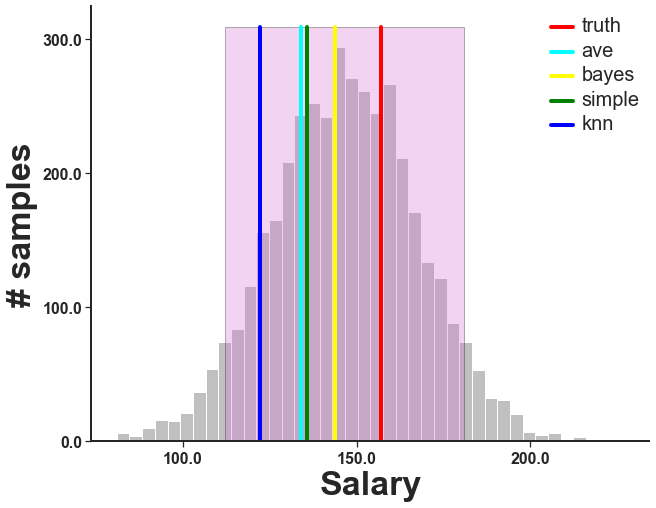

<class 'numpy.ndarray'>


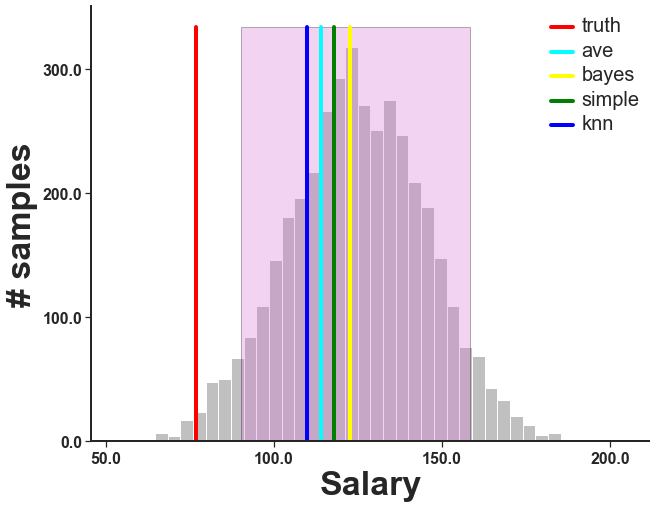

<class 'numpy.ndarray'>


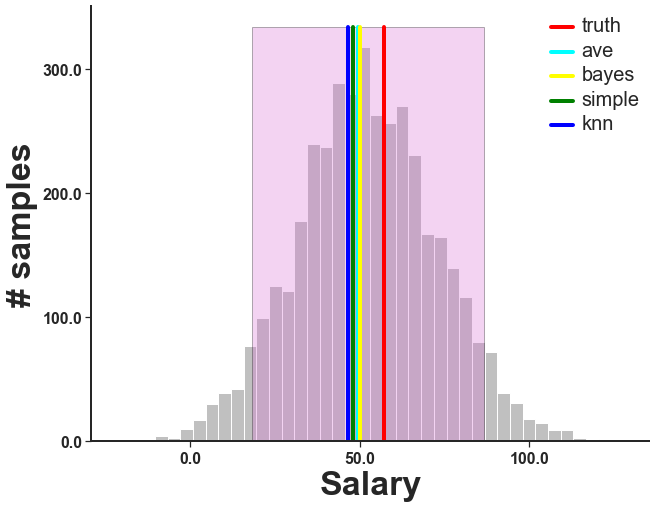

<class 'numpy.ndarray'>


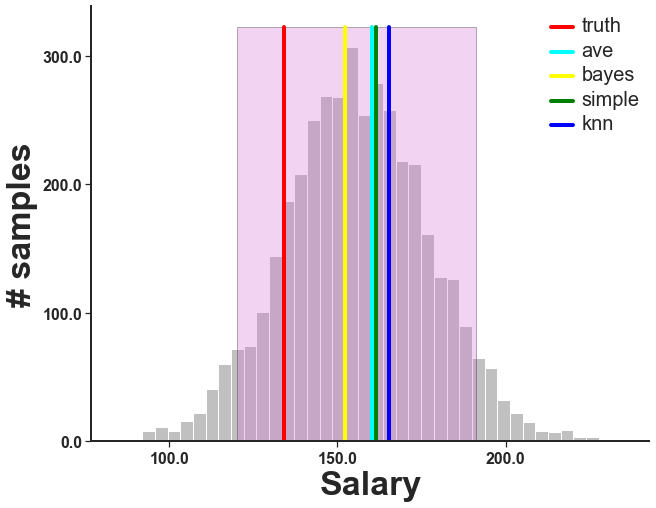

<class 'numpy.ndarray'>


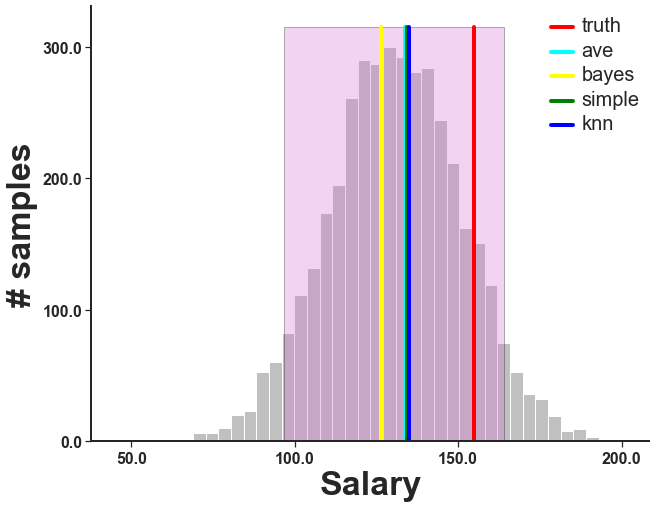

<class 'numpy.ndarray'>


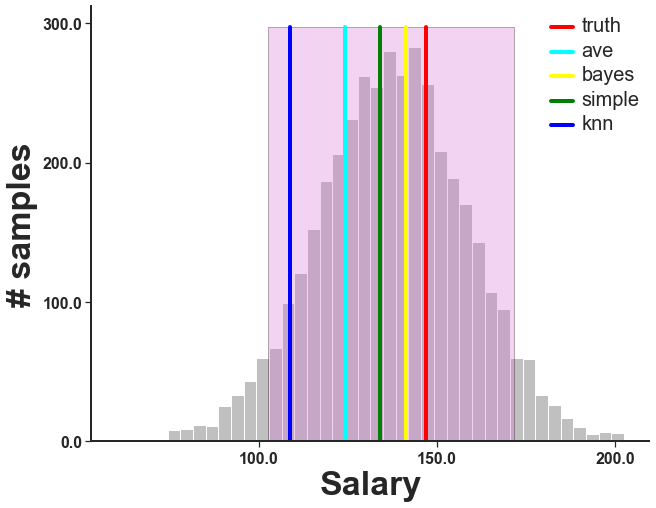

<class 'numpy.ndarray'>


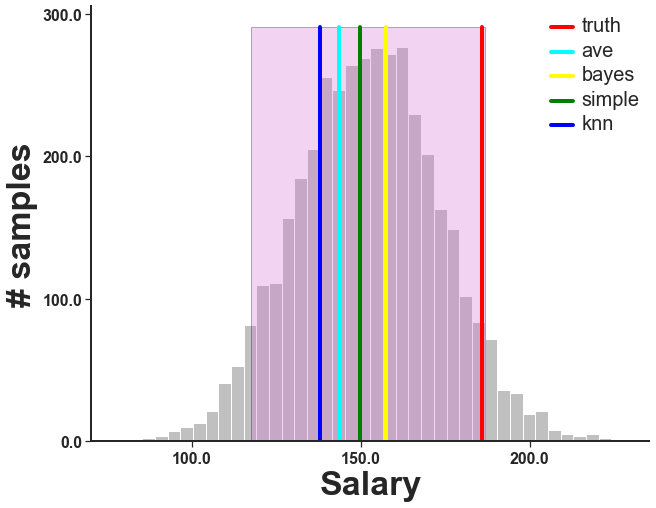

<class 'numpy.ndarray'>


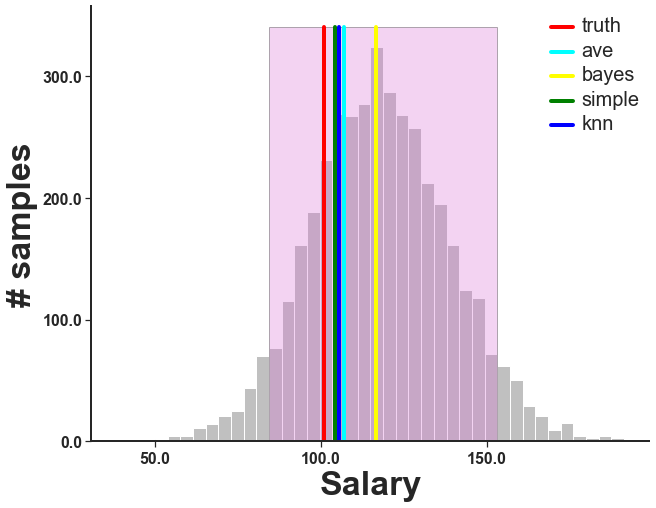

<class 'numpy.ndarray'>


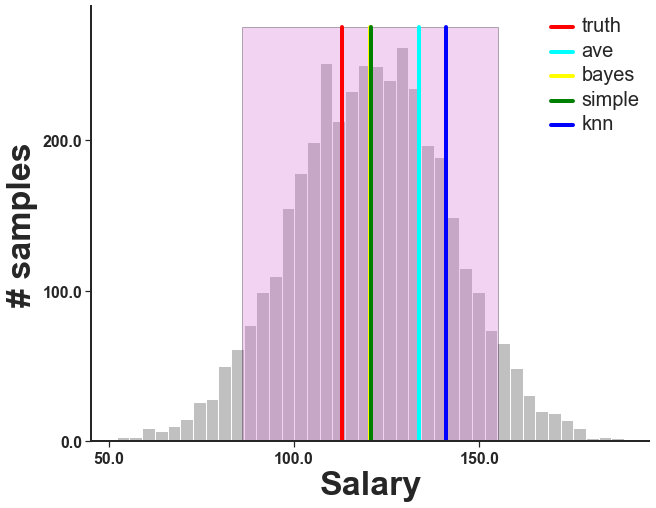

<class 'numpy.ndarray'>


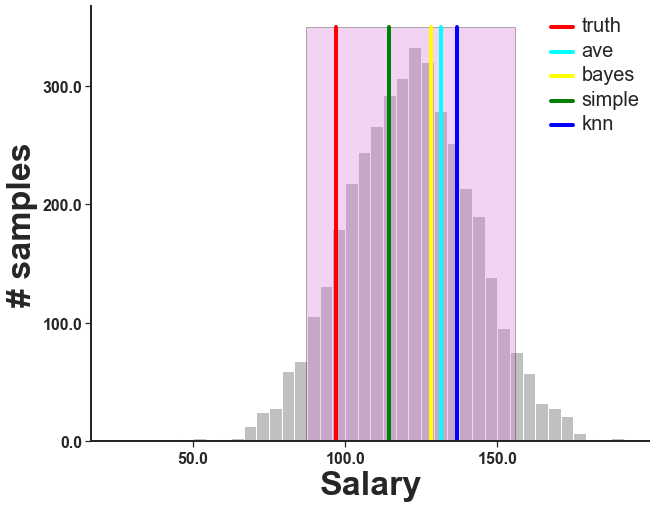

<class 'numpy.ndarray'>


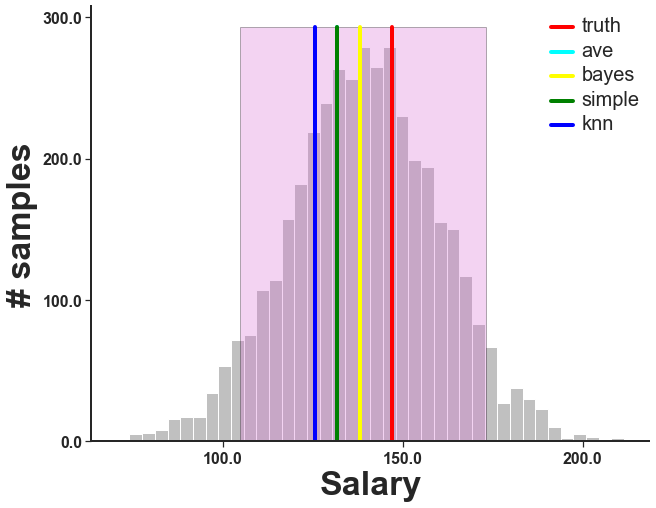

<class 'numpy.ndarray'>


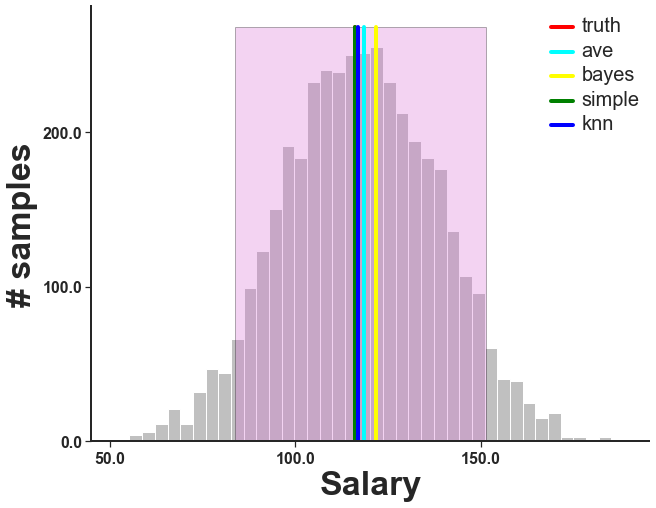

<class 'numpy.ndarray'>


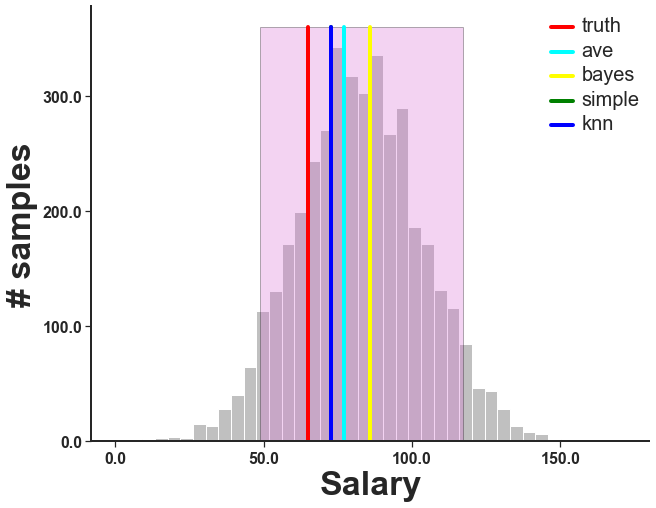

<class 'numpy.ndarray'>


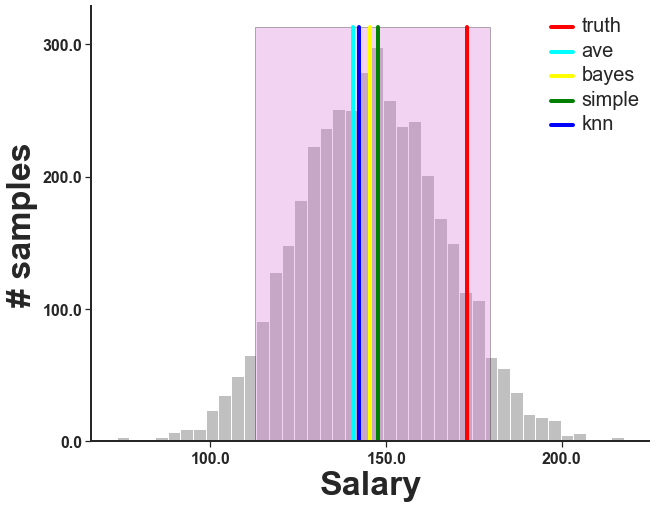

<class 'numpy.ndarray'>


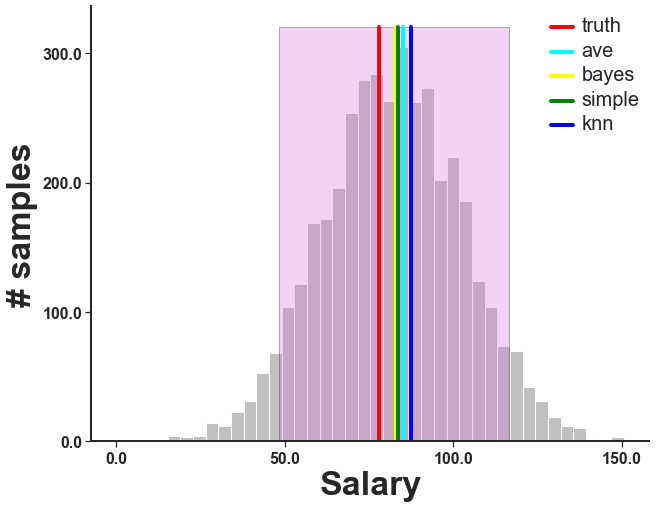

<class 'numpy.ndarray'>


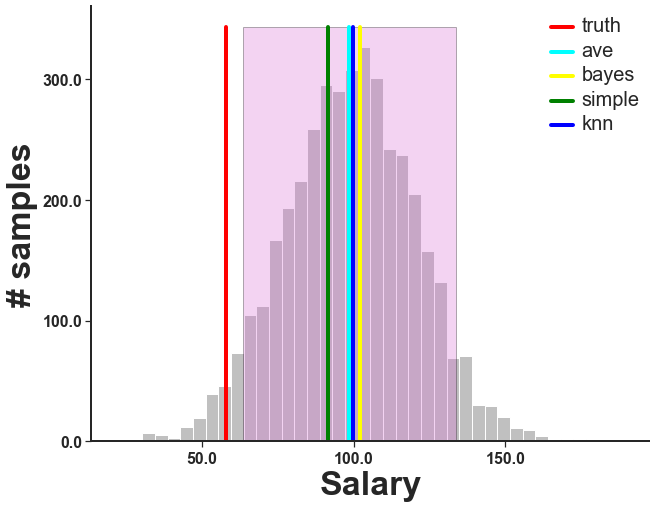

<class 'numpy.ndarray'>


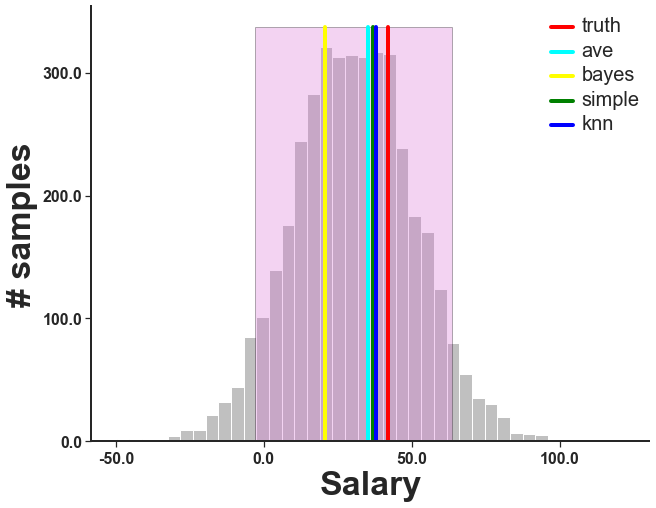

<class 'numpy.ndarray'>


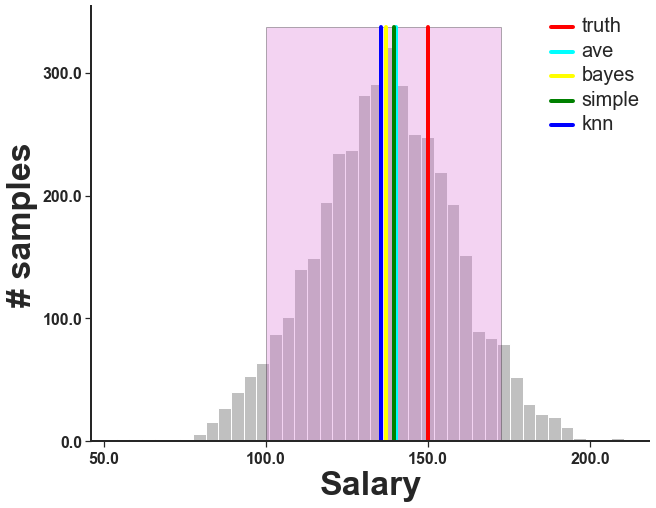

<class 'numpy.ndarray'>


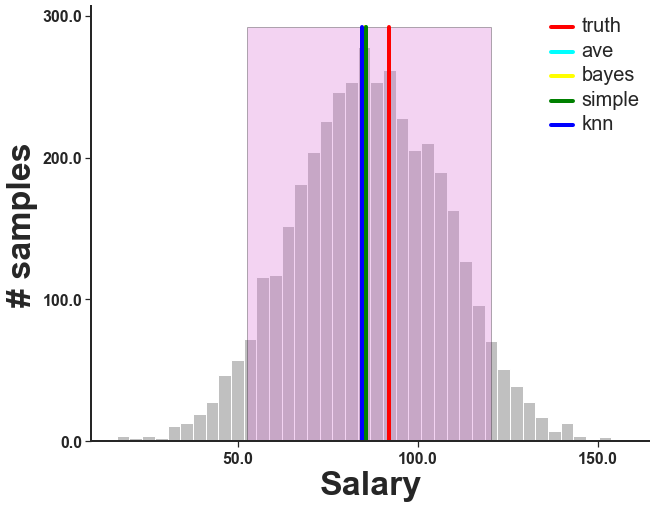

<class 'numpy.ndarray'>


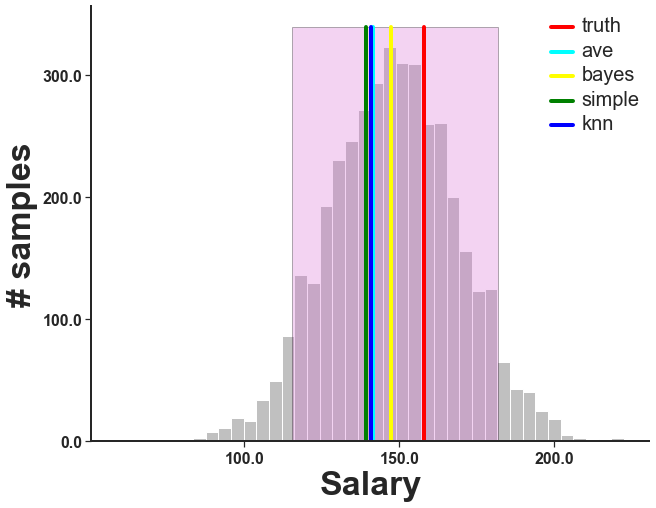

<class 'numpy.ndarray'>


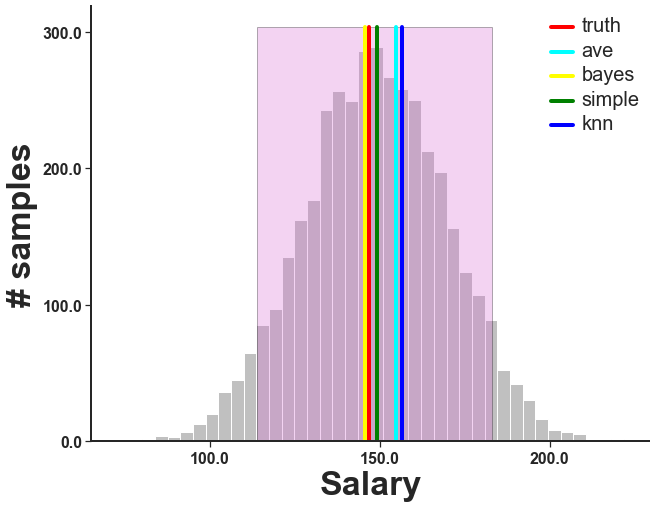

<class 'numpy.ndarray'>


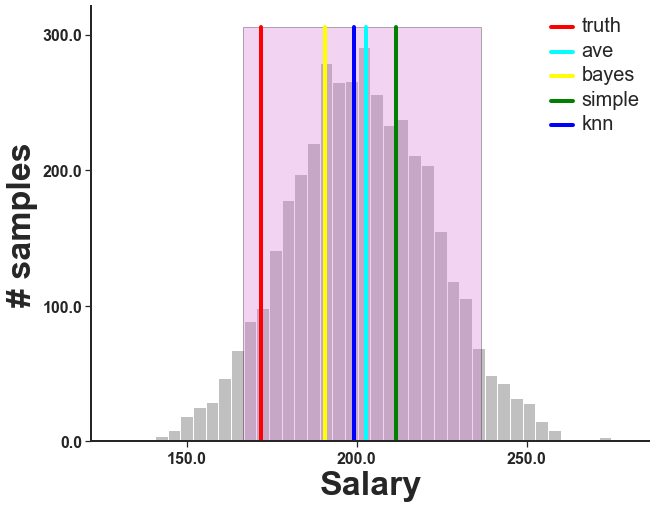

<class 'numpy.ndarray'>


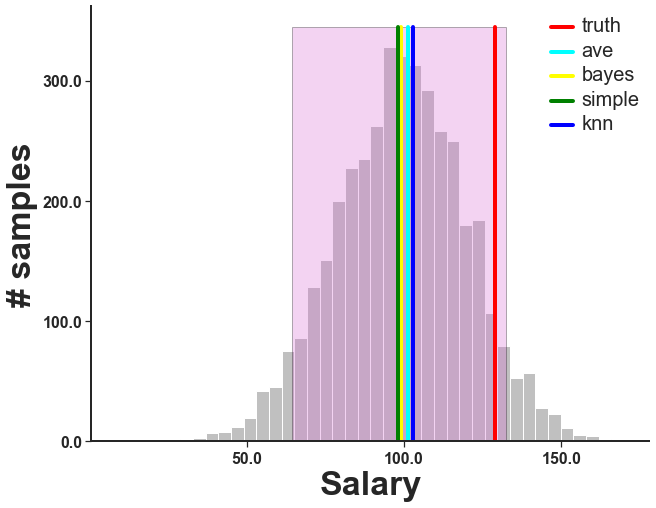

<class 'numpy.ndarray'>


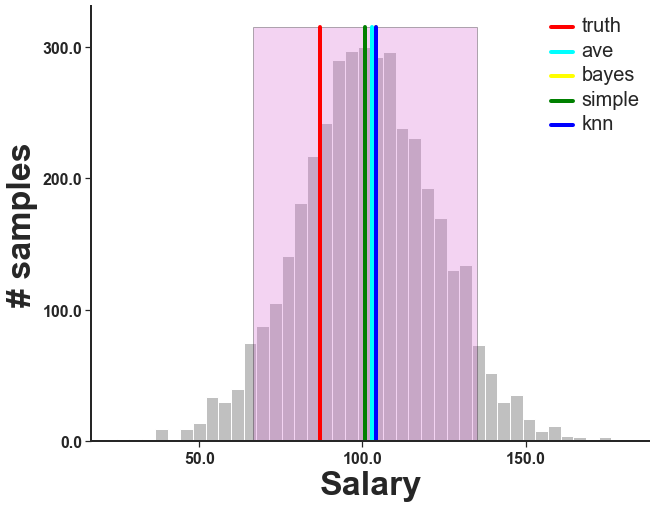

<class 'numpy.ndarray'>


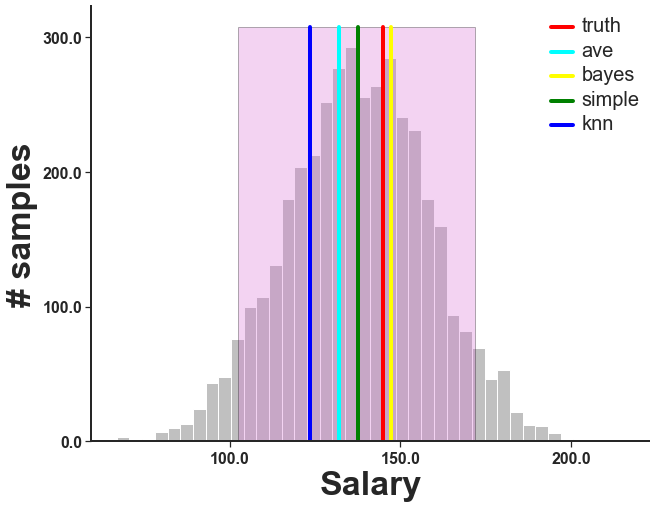

<class 'numpy.ndarray'>


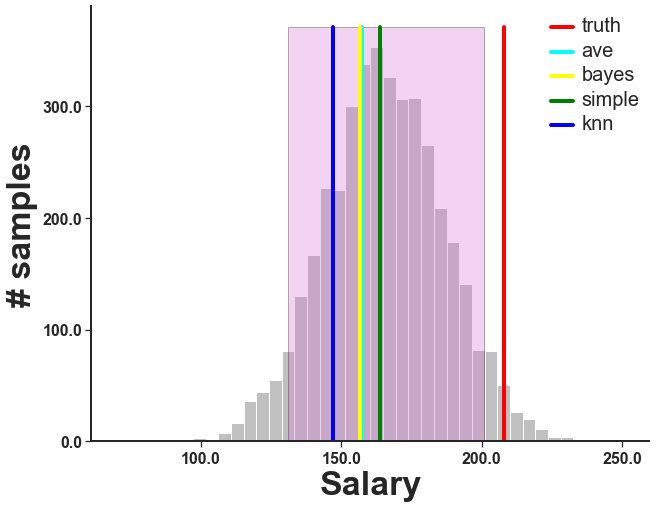

<class 'numpy.ndarray'>


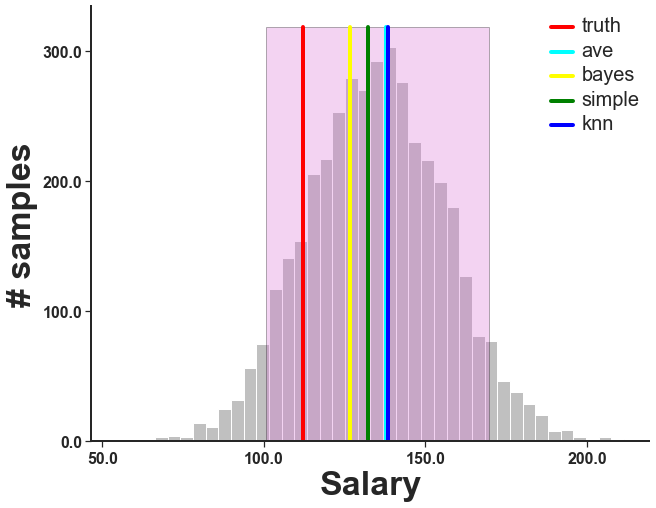

<class 'numpy.ndarray'>


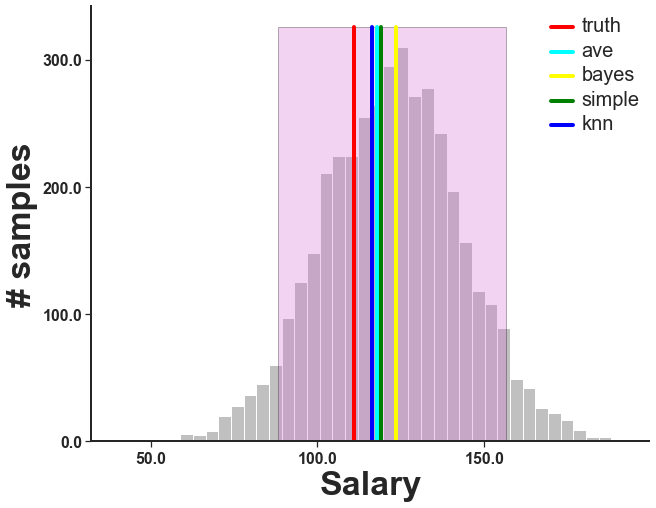

<class 'numpy.ndarray'>


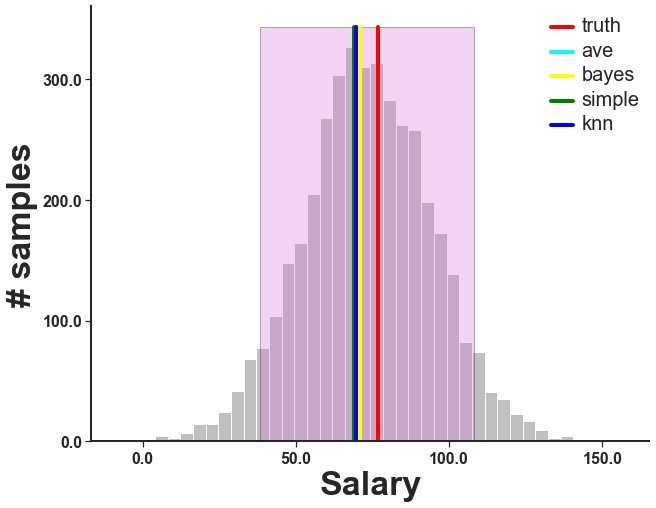

<class 'numpy.ndarray'>


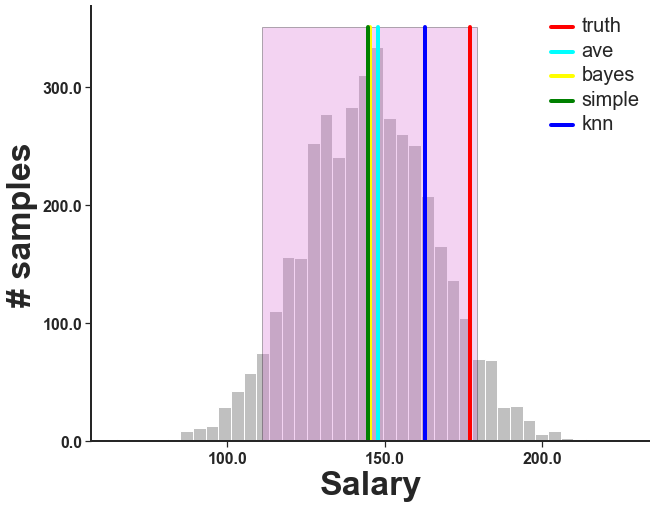

<class 'numpy.ndarray'>


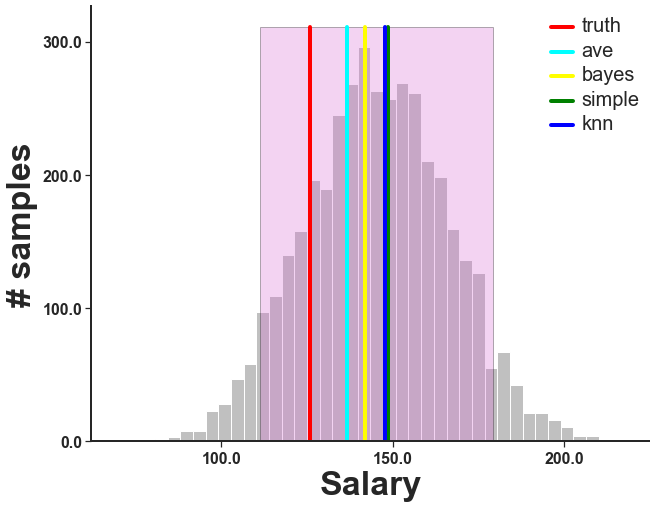

<class 'numpy.ndarray'>


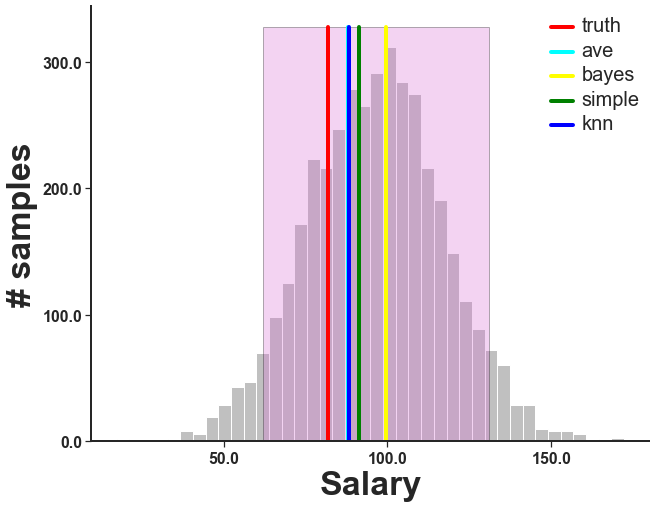

<class 'numpy.ndarray'>


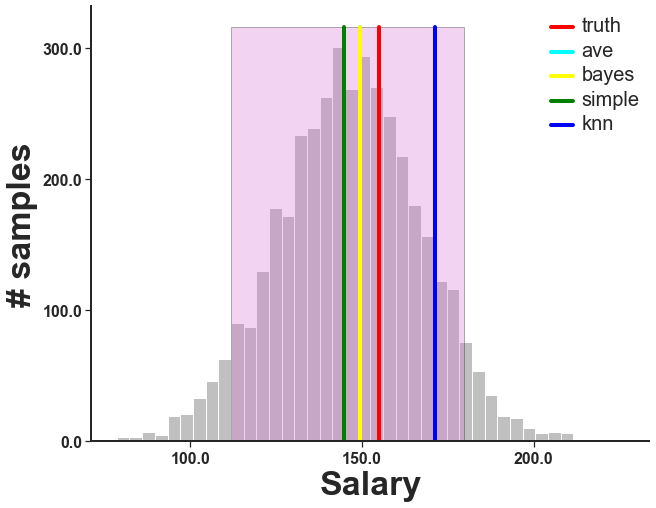

In [92]:
def add_lines(ax, c, method, y_hat):
    
    '''
    Function to plot lines over the credible inverval
    Inputs:
       ax: matplotlib axis on which to overlay the vertical line
       c: the chosen color of the line
       method: the name of the prediction method (e.g., Bayes, KNN, etc.)
       y_hat: the estimated salary from each method
       
    Outputs:
       None: simply modifies the graph
    '''
    
    ymin, ymax = ax.get_ybound()
    ax.add_line(mlines.Line2D([y_hat,y_hat], [ymin, ymax], 
                              color=c, linewidth=4)) 
    
    
def plot_estimates(n_plots):
    
    '''
    Function to plot the estimates over Bayesian credible area
    
    Inputs:  Number of plots to create
    Outputs: None.
    '''
    
    ##take a sample of the results for plotting
    ##verify n_plots < len(df_results)
    df = df_results.sample(n_plots)
    
    y_truth = df.y_truth.values
    y_hat_bayes = df.y_hat_bayes.values
    y_hat_simple = df.y_hat_simple.values
    y_hat_knn = df.y_hat_knn.values
    y_hat_ave = df.y_hat_ave.values
 
    posterior = df.posterior.values

    
    for i in range(n_plots):
        fig = plt.figure(figsize=(10,8))

        plt.hist(posterior[i], bins=40, color='silver')
        
        #find upper and lower credible intervals
        print(type(posterior[i]))
        lower, upper = np.percentile(posterior[i],[5,95])
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ymin, ymax = ax.get_ybound()   
           
        colors = ['red','cyan','yellow', 'green', 'blue']
        label_names = ['truth','ave','bayes','simple','knn']
         
        artists = []
        
        for color in colors:
            artists.append(plt.Line2D((0,1),(0,0), color=color, linewidth=4))
        
        add_lines(ax, 'red', 'y_truth',y_truth[i])
        add_lines(ax, 'cyan', 'y_hat_ave',y_hat_ave[i])
        add_lines(ax, 'yellow', 'y_hat_bayes',y_hat_bayes[i])
        add_lines(ax, 'green', 'y_hat_simple',y_hat_simple[i])     
        add_lines(ax, 'blue', 'y_hat_knn',y_hat_knn[i])
    
        ##add legend and area representing credi
        handles, labels = ax.get_legend_handles_labels()
        display = (0,1,2,3,4)
       
        #Create legend from custom artist/label lists 
        ax.legend([handle for i,handle in enumerate(handles) if i in display]+artists,
                  [label for i,label in enumerate(labels) if i in display]+label_names,
                   frameon=False)
        
        rect1 = plt.Rectangle((lower,0),(upper-lower),(ymax), 
                              facecolor="orchid",edgecolor="black",alpha=0.3)
        ax.add_patch(rect1)
        
        
        plt.setp(ax.get_legend().get_texts(), fontsize='20')
        #ax.set_ylim(0,)
        improve_plot(ax, 'Salary', '# samples', nyticks=5)
        plt.show()
        fig.savefig('./credible_'+str(i))
        
    
  

##show plots of posterior and estimate for methods
plot_estimates(100)


In [99]:
df_results.to_csv('./test_results.csv', columns=['y_truth', 'y_hat_nn'], index=False, header=True)